<h1>Probability of default modelling 

<h2>Loading libraries 

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, matthews_corrcoef
from imblearn.over_sampling import SMOTE, KMeansSMOTE, RandomOverSampler, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
import scipy.stats as stat
from scipy.stats import ks_2samp

<h2>Loading Data, and early data preparation

In [5]:
df_backup = pd.read_csv(r"C:\Users\macko\Downloads\loan_data_2007_2014.csv", delimiter = ",")

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\76637393.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_backup = pd.read_csv(r"C:\Users\macko\Downloads\loan_data_2007_2014.csv", delimiter = ",")


In [6]:
df = df_backup.copy()

In [7]:
df.head()

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

In [8]:
df = df.drop("Unnamed: 0", axis = 1)

In [9]:
df["term"].unique()
df["term"] = df["term"].str.replace("months", "")
df["term"] = pd.to_numeric(df["term"])
df["term"].unique()

array([36, 60])

In [10]:
df["emp_length"].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [11]:
df["emp_length"] = df["emp_length"].str.replace("years", "")
df["emp_length"] = df["emp_length"].str.replace("< 1", str(0))
df["emp_length"] = df["emp_length"].str.replace("year", "")
df["emp_length"] = df["emp_length"].str.replace("10+", str(10))
df["emp_length"] = pd.to_numeric(df["emp_length"])

df["emp_length"].unique()
                                                

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [12]:
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format = "%b-%y")

In [13]:
df["month_since_earliest_cr_line"] = round((pd.to_datetime("2017-12-01") - df["earliest_cr_line"]).dt.days/30)

df.loc[df["month_since_earliest_cr_line"] < 0, "month_since_earliest_cr_line"] += 1200
df["month_since_earliest_cr_line"].head()

0    401.0
1    227.0
2    196.0
3    266.0
4    267.0
Name: month_since_earliest_cr_line, dtype: float64

In [14]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format = "%b-%y")
df["issue_d"].tail(20)

466265   2014-01-01
466266   2014-01-01
466267   2014-01-01
466268   2014-01-01
466269   2014-01-01
466270   2014-01-01
466271   2014-01-01
466272   2014-01-01
466273   2014-01-01
466274   2014-01-01
466275   2014-01-01
466276   2014-01-01
466277   2014-01-01
466278   2014-01-01
466279   2014-01-01
466280   2014-01-01
466281   2014-01-01
466282   2014-01-01
466283   2014-01-01
466284   2014-01-01
Name: issue_d, dtype: datetime64[ns]

In [15]:
df["mths_since_issue_d"] = round((pd.to_datetime("2017-12-01") - df["issue_d"]).dt.days/30)
df["mths_since_issue_d"].describe()

count    466285.000000
mean         52.265887
std          14.385250
min          37.000000
25%          42.000000
50%          48.000000
75%          58.000000
max         128.000000
Name: mths_since_issue_d, dtype: float64

In [16]:
df["grade"].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [17]:
dummies =[pd.get_dummies(df["grade"], prefix = "grade:").astype(int),
          pd.get_dummies(df["sub_grade"], prefix = "grade:").astype(int),
          pd.get_dummies(df["home_ownership"], prefix = "home_ownership:").astype(int),
          pd.get_dummies(df["verification_status"], prefix = "verification_status:").astype(int),
          pd.get_dummies(df["loan_status"], prefix = "loan_status:").astype(int),
          pd.get_dummies(df["purpose"], prefix = "purpose:").astype(int),
          pd.get_dummies(df["addr_state"], prefix = "addr_state:").astype(int),
          pd.get_dummies(df["initial_list_status"], prefix = "initial_list_status:").astype(int),
          pd.get_dummies(df["acc_now_delinq"], prefix= "acc_now_delinq").astype(int)
         ]

dummies = pd.concat(dummies, axis = 1)
df = pd.concat((df, dummies), axis = 1)


In [372]:
pd.options.display.max_rows = 200
df.isnull().sum()


id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
                               ..
dti:>=28                        0
mths_since_last_delinq:_>=60    0
installment_cut                 0
installment:_<182               0
out_prncp_cut                   0
Length: 225, dtype: int64

In [22]:
df["month_since_earliest_cr_line"].fillna( 0, inplace = True)
df["acc_now_delinq"].fillna( 0, inplace = True)
df["total_acc"].fillna( 0, inplace = True)
df["pub_rec"].fillna( 0, inplace = True)
df["open_acc"].fillna( 0, inplace = True)
df["inq_last_6mths"].fillna( 0, inplace = True)
df["delinq_2yrs"].fillna( 0, inplace = True)
df["emp_length"].fillna( 0, inplace = True)
df['total_rev_hi_lim'].fillna( 0, inplace = True)


C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1417406581.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["month_since_earliest_cr_line"].fillna( 0, inplace = True)
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1417406581.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [23]:
df["loan_status"].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [24]:
df["good_bad"] = np.where(df["loan_status"].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)
df["good_bad"]

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: good_bad, Length: 466285, dtype: int64

In [374]:
#checking Balance
print(df["good_bad"].value_counts()/df["good_bad"].count())
# inputs data Frame
X = pd.DataFrame()


good_bad
1    0.890693
0    0.109307
Name: count, dtype: float64


<h2> Data preparation
<h3> Creating dummy vairables with respect to WoE similarity

In [27]:
def Woe_discrit(X, y, feature):
    df1 = pd.concat((X[feature], y), axis= 1)
    g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
                 df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)
    df1 = g_df.iloc[:, [0, 1, 3]]
    df1.columns = [df1.columns.values[0], "n_obs", "prob_good"]
    df1["prob_bad"] = 1-df1["prob_good"]
    df1["n_good"] = df1["prob_good"]*df1["n_obs"]
    df1["n_bad"] = df1["prob_bad"]*df1["n_obs"]
    df1["good%"] = df1["n_good"]/df1["n_good"].sum()
    df1["bad%"] = df1["n_bad"]/df1["n_bad"].sum()
    df1["WoE"] = np.log(df1["good%"]/df1["bad%"])
    df1 = df1.sort_values("WoE", ascending = False)
    return df1


In [28]:
df1= Woe_discrit(df, df["good_bad"], "addr_state")
df1

addr_state  n_obs  prob_good  prob_bad   n_good   n_bad     good%  \
21         ME      4   1.000000  0.000000      4.0     0.0  0.000010   
7          DC   1426   0.931978  0.068022   1329.0    97.0  0.003200   
49         WY   1128   0.926418  0.073582   1045.0    83.0  0.002516   
48         WV   2412   0.919569  0.080431   2218.0   194.0  0.005340   
29         NH   2232   0.917115  0.082885   2047.0   185.0  0.004929   
13         ID     12   0.916667  0.083333     11.0     1.0  0.000026   
25         MS   1226   0.914356  0.085644   1121.0   105.0  0.002699   
0          AK   1251   0.912870  0.087130   1142.0   109.0  0.002750   
45         VT    905   0.912707  0.087293    826.0    79.0  0.001989   
16         KS   4190   0.910501  0.089499   3815.0   375.0  0.009186   
39         SC   5583   0.908651  0.091349   5073.0   510.0  0.012215   
5          CO   9739   0.908615  0.091385   8849.0   890.0  0.021307   
26         MT   1396   0.906877  0.093123   1266.0   130.0  0.003048   
6          CT   7204   0.906302  0.093698   6529.0   675.0  0.015721   
14         IL  18612   0.905652  0.094348  16856.0  1756.0  0.040586   
42         TX  36439   0.904251  0.095749  32950.0  3489.0  0.079337   
36         OR   5949   0.899479  0.100521   5351.0   598.0  0.012884   
47         WI   5911   0.899171  0.100829   5315.0   596.0  0.012797   
46         WA  10517   0.897689  0.102311   9441.0  1076.0  0.022732   
10         GA  14975   0.896361  0.103639  13423.0  1552.0  0.032320   
15         IN   6525   0.894100  0.105900   5834.0   691.0  0.014047   
19         MA  11072   0.893605  0.106395   9894.0  1178.0  0.023823   
40         SD    980   0.892857  0.107143    875.0   105.0  0.002107   
23         MN   8158   0.892498  0.107502   7281.0   877.0  0.017531   
8          DE   1272   0.892296  0.107704   1135.0   137.0  0.002733   
17         KY   4438   0.891843  0.108157   3958.0   480.0  0.009530   
34         OH  15237   0.891842  0.108158  13589.0  1648.0  0.032720   
38         RI   2050   0.890732  0.109268   1826.0   224.0  0.004397   
37         PA  16424   0.889978  0.110022  14617.0  1807.0  0.035195   
2          AR   3488   0.889335  0.110665   3102.0   386.0  0.007469   
41         TN   5984   0.888870  0.111130   5319.0   665.0  0.012807   
43         UT   3428   0.888856  0.111144   3047.0   381.0  0.007337   
22         MI  11549   0.888735  0.111265  10264.0  1285.0  0.024714   
3          AZ  10712   0.888350  0.111650   9516.0  1196.0  0.022913   
4          CA  71450   0.886396  0.113604  63333.0  8117.0  0.152493   
44         VA  14222   0.886092  0.113908  12602.0  1620.0  0.030343   
30         NJ  18061   0.885665  0.114335  15996.0  2065.0  0.038515   
20         MD  10974   0.885274  0.114726   9715.0  1259.0  0.023392   
24         MO   7508   0.884923  0.115077   6644.0   864.0  0.015997   
27         NC  12682   0.884876  0.115124  11222.0  1460.0  0.027020   
35         OK   4117   0.884625  0.115375   3642.0   475.0  0.008769   
31         NM   2588   0.884467  0.115533   2289.0   299.0  0.005511   
18         LA   5489   0.883403  0.116597   4849.0   640.0  0.011675   
33         NY  40242   0.883182  0.116818  35541.0  4701.0  0.085576   
1          AL   5853   0.876474  0.123526   5130.0   723.0  0.012352   
9          FL  31637   0.874640  0.125360  27671.0  3966.0  0.066626   
11         HI   2487   0.873743  0.126257   2173.0   314.0  0.005232   
32         NV   6519   0.862862  0.137138   5625.0   894.0  0.013544   
12         IA     14   0.785714  0.214286     11.0     3.0  0.000026   
28         NE     14   0.428571  0.571429      6.0     8.0  0.000014   

        bad%       WoE  
21  0.000000       inf  
7   0.001903  0.519627  
49  0.001628  0.435087  
48  0.003806  0.338659  
29  0.003630  0.305931  
13  0.000020  0.300051  
25  0.002060  0.270172  
0   0.002139  0.251344  
45  0.001550  0.249303  
16  0.007358  0.221926  
39  0.010006  0.199433  
5   0.017462  0.198994  
26  0

In [29]:
def plot_WoE(data, feature, rotation_x = 0):
    plt.figure(figsize=(20, 12))
    plt.plot(data[feature].apply(str), data['WoE'], marker='o', linestyle='-', color='b')
    plt.title(f'Weight of Evidence (WoE) by {feature}', fontsize=12)
    plt.xlabel(f'{feature}', fontsize= 8)
    plt.ylabel('WoE', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation = rotation_x)
    plt.show()
    


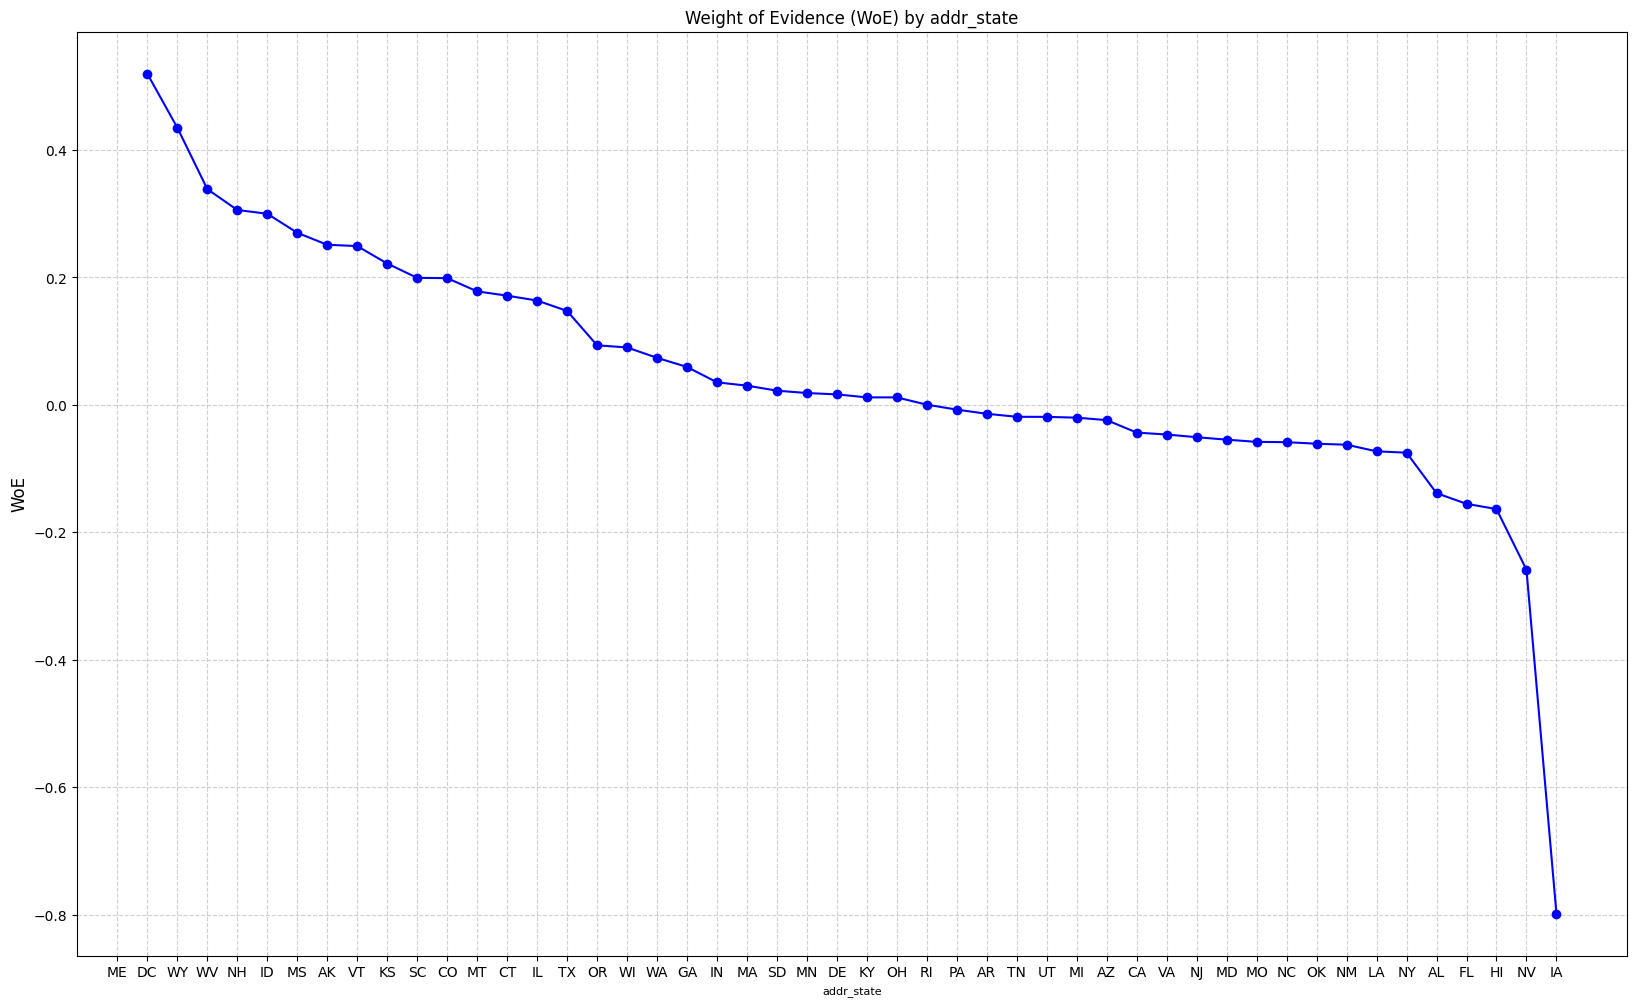

In [30]:
plot_WoE(df1.iloc[:-1, :], "addr_state")

In [375]:
X["addr_state:_NE_NV_HI_AL"] = sum((df["addr_state:_NE"],df["addr_state:_NV"],df["addr_state:_HI"],df["addr_state:_AL"]))
X["addr_state:_ME_DC_IA_WY_WV"] = sum((df["addr_state:_ME"],df["addr_state:_DC"],df["addr_state:_IA"],df["addr_state:_WY"],df["addr_state:_WV"]))
X["addr_state:_LA_OK_NM_NC"] = sum((df["addr_state:_LA"],df["addr_state:_OK"],df["addr_state:_NM"],df["addr_state:_NC"]))
X["addr_state:_NJ_VA_MD_MO"] = sum((df["addr_state:_NJ"],df["addr_state:_VA"],df["addr_state:_MD"], df["addr_state:_MO"]))
X["addr_state:_KS_MT_CO_SC"] = sum((df["addr_state:_KS"],df["addr_state:_MT"],df["addr_state:_CO"], df["addr_state:_SC"]))
X["addr_state:_CT_IL"] = sum((df["addr_state:_CT"],df["addr_state:_IL"]))
X["addr_state:_WI_OR_WA_GA"] = sum((df["addr_state:_WI"],df["addr_state:_OR"],df["addr_state:_WA"], df["addr_state:_GA"]))
X["addr_state:_MA_DE_IN"] = sum((df["addr_state:_MA"],df["addr_state:_DE"],df["addr_state:_IN"]))
X["addr_state:_KY_SD_MN"] = sum((df["addr_state:_MN"],df["addr_state:_KY"],df["addr_state:_SD"]))
X["addr_state:_TN_AZ_UT_MI"] = sum((df["addr_state:_TN"],df["addr_state:_AZ"],df["addr_state:_UT"],df["addr_state:_MI"]))
X["addr_state:_OH_PA_RI_AR"] = sum((df["addr_state:_OH"],df["addr_state:_PA"],df["addr_state:_RI"],df["addr_state:_AR"]))
X["addr_state:_TX"] = df["addr_state:_TX"]
X["addr_state:_NY"] = df["addr_state:_NY"]
X["addr_state:_CA"] = df["addr_state:_CA"]
X["addr_state:_FL"] = df["addr_state:_FL"]


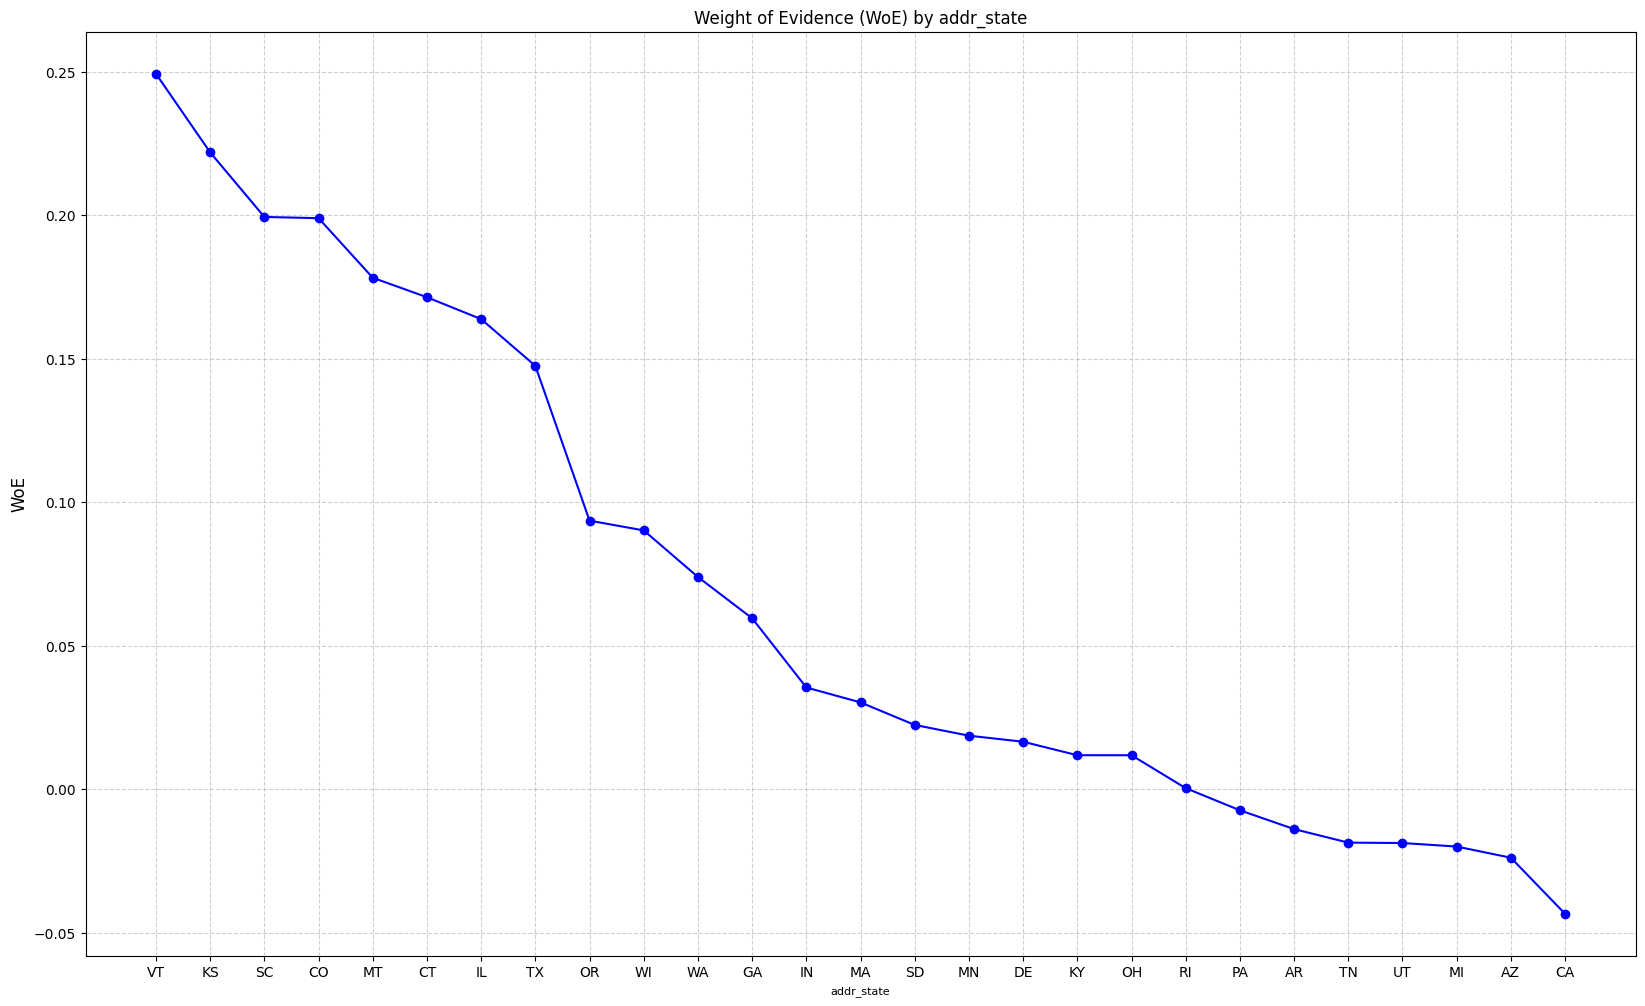

In [32]:
plot_WoE(df1.iloc[8:-15, :], "addr_state")

In [250]:
""" utworzone zmienne kategoryzujące: "addr_state:_NE_NV_HI_AL", "addr_state:_FL", "addr_state_ME_DC_IA_WY_WV","addr_state_LA_OK_NM_NC","addr_state_NY"
    "addr_state_NJ_VA_MD_MO", "addr_state_CA", "addr_state_KS_MT_CO_SC, "addr_state_VT_AK", "addr_state_CT_IL", "addr_state_TX, "addr_state_MA_DE_IN"
    "addr_state_KY_SD_MN","addr_state_TN_AZ_UT_MI", "addr_state_OH_PA_RI_AR"
    

In [376]:
X["home_ownership:_MORTGAGE"] = df["home_ownership:_MORTGAGE"]
X['home_ownership:_OWN'] = df["home_ownership:_OWN"]

In [313]:
df1 = Woe_discrit(df, df["good_bad"], "verification_status")
df1

verification_status   n_obs  prob_good  prob_bad    n_good    n_bad  \
0        Not Verified  148237   0.905921  0.094079  134291.0  13946.0   
1     Source Verified  149993   0.895882  0.104118  134376.0  15617.0   
2            Verified  168055   0.872631  0.127369  146650.0  21405.0   

      good%      bad%       WoE  
0  0.323346  0.273623  0.166972  
1  0.323550  0.306408  0.054438  
2  0.353104  0.419969 -0.173420

In [379]:
#plot_WoE(df1, "verification_status")

X["verification_status:_Source Verified"] = df["verification_status:_Source Verified"]
X["verification_status:_Verified"]= df["verification_status:_Verified"]
# Zostawiamy : "Verified","Source Verified"

In [315]:
df1 = Woe_discrit(df, df["good_bad"], "grade")
df1
df["grade:_A"]

0         0
1         0
2         0
3         0
4         0
         ..
466280    0
466281    0
466282    0
466283    1
466284    0
Name: grade:_A, Length: 466285, dtype: int64

In [384]:
X.columns

Index(['addr_state:_NE_NV_HI_AL', 'addr_state:_ME_DC_IA_WY_WV',
       'addr_state:_LA_OK_NM_NC', 'addr_state:_NJ_VA_MD_MO',
       'addr_state:_KS_MT_CO_SC', 'addr_state:_CT_IL',
       'addr_state:_WI_OR_WA_GA', 'addr_state:_MA_DE_IN',
       'addr_state:_KY_SD_MN', 'addr_state:_TN_AZ_UT_MI',
       'addr_state:_OH_PA_RI_AR', 'addr_state:_TX', 'addr_state:_NY',
       'addr_state:_CA', 'addr_state:_FL', 'home_ownership:_MORTGAGE',
       'home_ownership:_OWN', 'verification_status:_Source Verified',
       'verification_status:_Verified'],
      dtype='object')

In [386]:
plot_WoE(df1, "grade")
#Zostawiamy "A","B","C","D","E","F","G",
X["grade:A"] = df["grade:_A"]
X["grade:B"] = df["grade:_B"]
X["grade:C"] = df["grade:_C"]
X["grade:D"] = df["grade:_D"]
X["grade:E"] = df["grade:_E"]
X["grade:F"] = df["grade:_F"]

In [295]:
df1 = Woe_discrit(df, df["good_bad"], "purpose")
df1

purpose   n_obs  prob_good  prob_bad    n_good    n_bad  \
1          credit_card  104157   0.913774  0.086226   95176.0   8981.0   
0                  car    5397   0.910876  0.089124    4916.0    481.0   
6       major_purchase    9828   0.904457  0.095543    8889.0    939.0   
4     home_improvement   26537   0.901835  0.098165   23932.0   2605.0   
2   debt_consolidation  274195   0.886690  0.113310  243126.0  31069.0   
12            vacation    2487   0.882187  0.117813    2194.0    293.0   
13             wedding    2343   0.878361  0.121639    2058.0    285.0   
7              medical    4602   0.866145  0.133855    3986.0    616.0   
9                other   23690   0.862009  0.137991   20421.0   3269.0   
5                house    2269   0.859850  0.140150    1951.0    318.0   
8               moving    2994   0.847361  0.152639    2537.0    457.0   
10    renewable_energy     351   0.846154  0.153846     297.0     54.0   
3          educational     422   0.791469  0.208531     334.0     88.0   
11      small_business    7013   0.784258  0.215742    5500.0   1513.0   

       good%      bad%       WoE  
1   0.229165  0.176209  0.262772  
0   0.011837  0.009437  0.226539  
6   0.021403  0.018423  0.149910  
4   0.057623  0.051111  0.119940  
2   0.585399  0.609579 -0.040475  
12  0.005283  0.005749 -0.084535  
13  0.004955  0.005592 -0.120843  
7   0.009597  0.012086 -0.230548  
9   0.049170  0.064138 -0.265764  
5   0.004698  0.006239 -0.283798  
8   0.006109  0.008966 -0.383790  
10  0.000715  0.001059 -0.393096  
3   0.000804  0.001727 -0.764040  
11  0.013243  0.029685 -0.807190

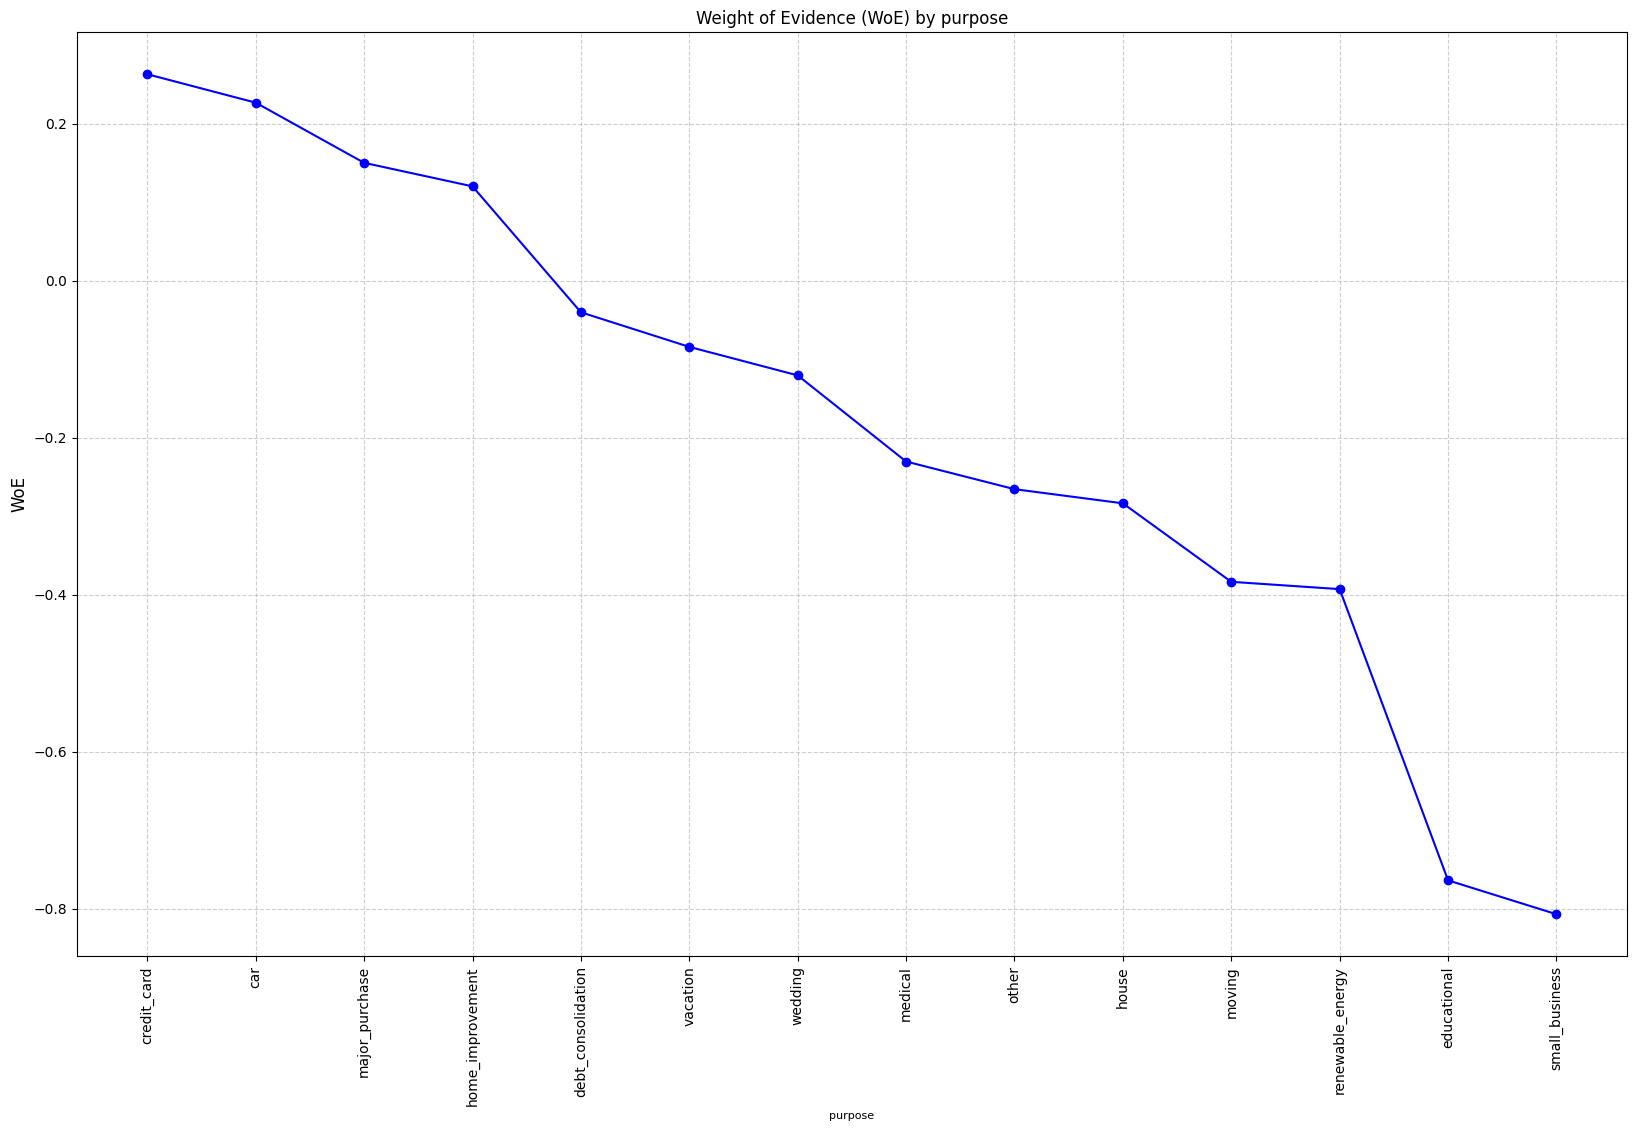

In [298]:
plot_WoE(df1, "purpose", 90)

In [387]:
X["purpose:renewable_energy_&_moving"] = sum((df["purpose:_renewable_energy"],df["purpose:_moving"]))
X["purpose:house_other_medical"] = sum((df["purpose:_house"],df["purpose:_other"],df["purpose:_medical"]))
X["purpose:wedding_vacation"] = sum((df["purpose:_wedding"],df["purpose:_vacation"]))
X["purpose:credit_card"] = df["purpose:_credit_card"]
X["purpose:debt_consolidation"] = df["purpose:_debt_consolidation"]


In [274]:
""" nowe zmienne: "purpose:_renewable_energy_&_moving", "purpose:_house_other_medical","purpose:_wedding_vacation",
    "purpose:_home_improvement_&_major_purchase_&_car", "purpose:_credit_card", "purpose:_debt_consolidation"  
    

SyntaxError: incomplete input (3298993758.py, line 1)

In [388]:
df1 = Woe_discrit(df, df["good_bad"], "initial_list_status")

#zostawiamy "w" i "f"
X["initial_list_status:f"] = df["initial_list_status:_f"]


In [44]:
def Woe_continuous(X, y, feature):
    df1 = pd.concat((X[feature], y), axis= 1)
    g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
                 df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)
    df1 = g_df.iloc[:, [0, 1, 3]]
    df1.columns = [df1.columns.values[0], "n_obs", "prob_good"]
    df1["prob_bad"] = 1-df1["prob_good"]
    df1["n_good"] = df1["prob_good"]*df1["n_obs"]
    df1["n_bad"] = df1["prob_bad"]*df1["n_obs"]
    df1["good%"] = df1["n_good"]/df1["n_good"].sum()
    df1["bad%"] = df1["n_bad"]/df1["n_bad"].sum()
    df1["WoE"] = np.log(df1["good%"]/df1["bad%"])   
    return df1
    

In [45]:
df["emp_length"].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.])

In [46]:
df1 = Woe_continuous(df, df["good_bad"], "emp_length")
df1

emp_length   n_obs  prob_good  prob_bad    n_good    n_bad     good%  \
0          0.0   57273   0.876015  0.123985   50172.0   7101.0  0.120804   
1          1.0   29622   0.888124  0.111876   26308.0   3314.0  0.063344   
2          2.0   41373   0.890242  0.109758   36832.0   4541.0  0.088684   
3          3.0   36596   0.890480  0.109520   32588.0   4008.0  0.078465   
4          4.0   28023   0.890411  0.109589   24952.0   3071.0  0.060079   
5          5.0   30774   0.885033  0.114967   27236.0   3538.0  0.065579   
6          6.0   26112   0.882889  0.117111   23054.0   3058.0  0.055509   
7          7.0   26180   0.888655  0.111345   23265.0   2915.0  0.056017   
8          8.0   22395   0.889931  0.110069   19930.0   2465.0  0.047987   
9          9.0   17888   0.887914  0.112086   15883.0   2005.0  0.038243   
10        10.0  150049   0.900353  0.099647  135097.0  14952.0  0.325286   

        bad%       WoE  
0   0.139323 -0.142623  
1   0.065021 -0.026127  
2   0.089095 -0.004624  
3   0.078638 -0.002192  
4   0.060253 -0.002893  
5   0.069416 -0.056866  
6   0.059998 -0.077766  
7   0.057193 -0.020764  
8   0.048364 -0.007810  
9   0.039338 -0.028239  
10  0.293361  0.103304

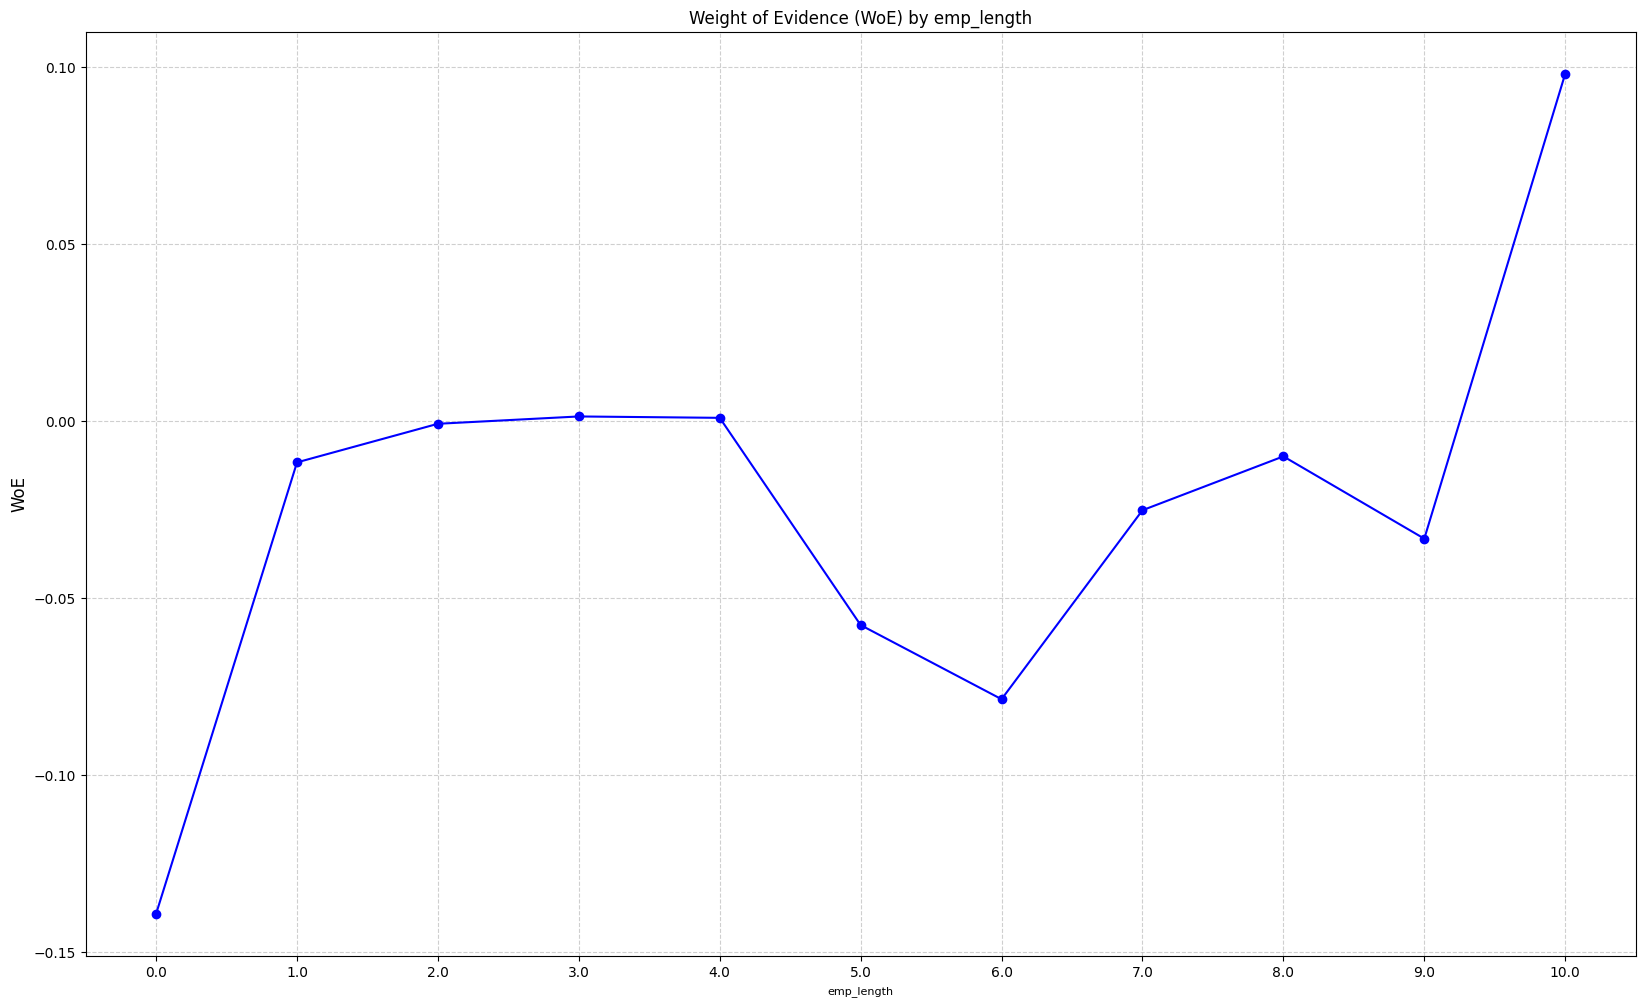

In [132]:
plot_WoE(df1, "emp_length")

In [390]:
df["emp_length:0"] = np.where(df["emp_length"] == 0, 1, 0)
X["emp_length:1-4"] = np.where(df["emp_length"].isin(range(1,5)), 1, 0)
X["emp_length:5-6"] = np.where(df["emp_length"].isin(range(5,7)), 1, 0)
X["emp_length:7-9"] = np.where(df["emp_length"].isin(range(7,10)), 1, 0)
X["emp_length:10"] = np.where(df["emp_length"] == 10 , 1, 0)

# Nowe zmienne: "emp_length:_0", "emp_length:_1_4", "emp_length:_5_6", "emp_length:_7_9", "emp_length:_10"

In [389]:
df["term:_60"] = np.where(df["term"] == 60, 1, 0)
X["term:36"] = np.where(df["term"] == 36, 1, 0)
#Nowe Zmienne "term:_36" 

In [301]:
df1 = Woe_continuous(df, df["good_bad"], "mths_since_issue_d")
df1

mths_since_issue_d  n_obs  prob_good  prob_bad   n_good   n_bad     good%  \
0                 37.0  10307   0.948385  0.051615   9775.0   532.0  0.023536   
1                 38.0  25054   0.940728  0.059272  23569.0  1485.0  0.056749   
2                 39.0  38782   0.930406  0.069594  36083.0  2699.0  0.086881   
3                 40.0  10606   0.922968  0.077032   9789.0   817.0  0.023570   
4                 41.0  18814   0.920166  0.079834  17312.0  1502.0  0.041684   
..                 ...    ...        ...       ...      ...     ...       ...   
86               124.0    105   0.676190  0.323810     71.0    34.0  0.000171   
87               125.0     53   0.754717  0.245283     40.0    13.0  0.000096   
88               126.0     74   0.729730  0.270270     54.0    20.0  0.000130   
89               127.0     63   0.888889  0.111111     56.0     7.0  0.000135   
90               128.0     24   0.875000  0.125000     21.0     3.0  0.000051   

        bad%       WoE  
0   0.010438  0.813096  
1   0.029136  0.666673  
2   0.052955  0.495096  
3   0.016030  0.385531  
4   0.029469  0.346758  
..       ...       ...  
86  0.000667 -1.361525  
87  0.000255 -0.973914  
88  0.000392 -1.104592  
89  0.000137 -0.018403  
90  0.000059 -0.151934  

[91 rows x 9 columns]

In [51]:
df["mths_since_issue_d_cut"] = pd.cut(df["mths_since_issue_d"], 50)
df1 = Woe_continuous(df, df["good_bad"], "mths_since_issue_d_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


mths_since_issue_d_cut  n_obs  prob_good  prob_bad   n_good   n_bad  \
0         (36.909, 38.82]  35361   0.942960  0.057040  33344.0  2017.0   
1          (38.82, 40.64]  49388   0.928809  0.071191  45872.0  3516.0   
2          (40.64, 42.46]  48120   0.917810  0.082190  44165.0  3955.0   
3          (42.46, 44.28]  36278   0.908705  0.091295  32966.0  3312.0   
4           (44.28, 46.1]  35584   0.902007  0.097993  32097.0  3487.0   
5           (46.1, 47.92]  15269   0.898487  0.101513  13719.0  1550.0   
6          (47.92, 49.74]  30648   0.897155  0.102845  27496.0  3152.0   
7          (49.74, 51.56]  28790   0.887843  0.112157  25561.0  3229.0   
8          (51.56, 53.38]  25661   0.880207  0.119793  22587.0  3074.0   
9           (53.38, 55.2]  22809   0.868298  0.131702  19805.0  3004.0   
10          (55.2, 57.02]  19769   0.858819  0.141181  16978.0  2791.0   
11         (57.02, 58.84]   8273   0.866916  0.133084   7172.0  1101.0   
12         (58.84, 60.66]  14433   0.857895  0.142105  12382.0  2051.0   
13         (60.66, 62.48]  12448   0.851783  0.148217  10603.0  1845.0   
14          (62.48, 64.3]  12350   0.851903  0.148097  10521.0  1829.0   
15          (64.3, 66.12]  10046   0.835357  0.164643   8392.0  1654.0   
16         (66.12, 67.94]   3817   0.819230  0.180770   3127.0   690.0   
17         (67.94, 69.76]   6630   0.843439  0.156561   5592.0  1038.0   
18         (69.76, 71.58]   5474   0.845269  0.154731   4627.0   847.0   
19          (71.58, 73.4]   4869   0.825221  0.174779   4018.0   851.0   
20          (73.4, 75.22]   4350   0.852184  0.147816   3707.0   643.0   
21         (75.22, 77.04]   4001   0.856036  0.143964   3425.0   576.0   
22         (77.04, 78.86]   1875   0.852267  0.147733   1598.0   277.0   
23         (78.86, 80.68]   3539   0.842611  0.157389   2982.0   557.0   
24          (80.68, 82.5]   3011   0.856858  0.143142   2580.0   431.0   
25          (82.5, 84.32]   2678   0.867438  0.132562   2323.0   355.0   
26         (84.32, 86.14]   2559   0.868699  0.131301   2223.0   336.0   
27         (86.14, 87.96]   1232   0.845779  0.154221   1042.0   190.0   
28         (87.96, 89.78]   2364   0.839679  0.160321   1985.0   379.0   
29          (89.78, 91.6]   2309   0.846254  0.153746   1954.0   355.0   
30          (91.6, 93.42]   1901   0.871120  0.128880   1656.0   245.0   
31         (93.42, 95.24]   1510   0.892715  0.107285   1348.0   162.0   
32         (95.24, 97.06]   1320   0.876515  0.123485   1157.0   163.0   
33         (97.06, 98.88]    662   0.853474  0.146526    565.0    97.0   
34         (98.88, 100.7]   1111   0.850585  0.149415    945.0   166.0   
35        (100.7, 102.52]    857   0.873979  0.126021    749.0   108.0   
36       (102.52, 104.34]    406   0.857143  0.142857    348.0    58.0   
37       (104.34, 106.16]    692   0.855491  0.144509    592.0   100.0   
38       (106.16, 107.98]    324   0.873457  0.126543    283.0    41.0   
39        (107.98, 109.8]    571   0.856392  0.143608    489.0    82.0   
40        (109.8, 111.62]    462   0.829004  0.170996    383.0    79.0   
41       (111.62, 113.44]    179   0.826816  0.173184    148.0    31.0   
42       (113.44, 115.26]    241   0.825726  0.174274    199.0    42.0   
43       (115.26, 117.08]    239   0.803347  0.196653    192.0    47.0   
44        (117.08, 118.9]    259   0.756757  0.243243    196.0    63.0   
45        (118.9, 120.72]    708   0.788136  0.211864    558.0   150.0   
46       (120.72, 122.54]    477   0.725367  0.274633    346.0   131.0   
47       (122.54, 124.36]    217   0.686636  0.313364    149.0    68.0   
48       (124.36, 126.18]    127   0.740157  0.259843     94.0    33.0   
49        (126.18, 128.0]     87   0.885057  0.114943     77.0    10.0   

       good%      bad%       WoE  
0   0.080286  0.039574  0.707422  
1   0.110451  0.068984  0.470687  
2   0.106340  0.077598  0.315108  
3   0.079376  0.064982  0.200080  
4   0.077283  0.068415  0.121877  
5   0.033033  0.03

In [542]:
plot_WoE(df1, "mths_since_issue_d_cut", 90)

KeyError: 'mths_since_issue_d_cut'

<Figure size 2000x1200 with 0 Axes>

In [391]:
df["mths_since_issue_d_cut:_>=84"] = np.where(df["mths_since_issue_d"].isin(range(84,129)), 1, 0)
X["mths_since_issue_d:<64,84)"] = np.where(df["mths_since_issue_d"].isin(range(64,84)), 1, 0)
X["mths_since_issue_d:<54,64)"] = np.where(df["mths_since_issue_d"].isin(range(54,64)), 1, 0)
X["mths_since_issue_d:<51,54)"] = np.where(df["mths_since_issue_d"].isin(range(51,54)), 1, 0)
X["mths_since_issue_d:<42,51)"] = np.where(df["mths_since_issue_d"].isin(range(42,51)), 1, 0)
X["mths_since_issue_d:<40,42)"] = np.where(df["mths_since_issue_d"].isin(range(40,42)), 1, 0)
X["mths_since_issue_d:<39,40)"] = np.where(df["mths_since_issue_d"].isin(range(39,40)), 1, 0)
X["mths_since_issue_d:<36,39)"] = np.where(df["mths_since_issue_d"].isin(range(36,39)), 1, 0)

#Nowe Zmienne: "mths_since_issue_d_cut:_>=84", "mths_since_issue_d_cut:_<64,84)", "mths_since_issue_d_cut:_<54,64)", "mths_since_issue_d_cut:_<51,54)" "mths_since_issue_d_cut:_<42,51)" , "mths_since_issue_d_cut:_<40,42)", "mths_since_issue_d_cut:_<39,40), "mths_since_issue_d_cut:_<36,39)"

In [321]:
X['total_rev_hi_lim:5K-10K'] = np.where(df['total_rev_hi_lim'].isin(range(5000,10000)),1,0)
X['total_rev_hi_lim:10K-20K'] = np.where(df['total_rev_hi_lim'].isin(range(10000,20000)),1,0)
X['total_rev_hi_lim:20K-30K'] = np.where(df['total_rev_hi_lim'].isin(range(20000,30000)),1,0)
X['total_rev_hi_lim:30K-40K'] = np.where(df['total_rev_hi_lim'].isin(range(30000,40000)),1,0)
X['total_rev_hi_lim:40K-55K'] = np.where(df['total_rev_hi_lim'].isin(range(40000,55000)),1,0)
X['total_rev_hi_lim:55K-95K'] = np.where(df['total_rev_hi_lim'].isin(range(55000,95000)),1,0)
X['total_rev_hi_lim:>95K'] = np.where(df['total_rev_hi_lim'] > 950000,1,0)

TypeError: Invalid comparison between dtype=category and int

In [58]:
df["int_rate_cut"] = pd.cut(df["int_rate"], 50)
df1 = Woe_continuous(df, df["good_bad"], "int_rate_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


int_rate_cut  n_obs  prob_good  prob_bad   n_good   n_bad     good%  \
0     (5.399, 5.833]    983   0.963377  0.036623    947.0    36.0  0.002280   
1     (5.833, 6.246]  10545   0.980275  0.019725  10337.0   208.0  0.024889   
2     (6.246, 6.658]   9800   0.971633  0.028367   9522.0   278.0  0.022927   
3     (6.658, 7.071]   2293   0.968600  0.031400   2221.0    72.0  0.005348   
4     (7.071, 7.484]   3947   0.977451  0.022549   3858.0    89.0  0.009289   
5     (7.484, 7.897]  15826   0.962972  0.037028  15240.0   586.0  0.036695   
6      (7.897, 8.31]  12116   0.949653  0.050347  11506.0   610.0  0.027704   
7      (8.31, 8.722]   8274   0.965313  0.034687   7987.0   287.0  0.019231   
8     (8.722, 9.135]  11923   0.938354  0.061646  11188.0   735.0  0.026938   
9     (9.135, 9.548]   8271   0.966389  0.033611   7993.0   278.0  0.019246   
10    (9.548, 9.961]   9469   0.931777  0.068223   8823.0   646.0  0.021244   
11   (9.961, 10.374]  13707   0.934194  0.065806  12805.0   902.0  0.030832   
12  (10.374, 10.786]   7247   0.914447  0.085553   6627.0   620.0  0.015956   
13  (10.786, 11.199]  22315   0.931167  0.068833  20779.0  1536.0  0.050032   
14  (11.199, 11.612]   6089   0.918377  0.081623   5592.0   497.0  0.013464   
15  (11.612, 12.025]  19334   0.932813  0.067187  18035.0  1299.0  0.043425   
16  (12.025, 12.438]  15413   0.895153  0.104847  13797.0  1616.0  0.033220   
17   (12.438, 12.85]  13819   0.922353  0.077647  12746.0  1073.0  0.030690   
18   (12.85, 13.263]  26769   0.903172  0.096828  24177.0  2592.0  0.058213   
19  (13.263, 13.676]  19198   0.905771  0.094229  17389.0  1809.0  0.041869   
20  (13.676, 14.089]  13683   0.896441  0.103559  12266.0  1417.0  0.029534   
21  (14.089, 14.502]  29196   0.887587  0.112413  25914.0  3282.0  0.062396   
22  (14.502, 14.914]   5520   0.863949  0.136051   4769.0   751.0  0.011483   
23  (14.914, 15.327]  23743   0.881902  0.118098  20939.0  2804.0  0.050417   
24   (15.327, 15.74]  15473   0.887352  0.112648  13730.0  1743.0  0.033059   
25   (15.74, 16.153]   9346   0.838648  0.161352   7838.0  1508.0  0.018872   
26  (16.153, 16.566]  16221   0.857469  0.142531  13909.0  2312.0  0.033490   
27  (16.566, 16.978]   5272   0.844461  0.155539   4452.0   820.0  0.010720   
28  (16.978, 17.391]  14239   0.852448  0.147552  12138.0  2101.0  0.029226   
29  (17.391, 17.804]  15280   0.839071  0.160929  12821.0  2459.0  0.030870   
30  (17.804, 18.217]   1592   0.825377  0.174623   1314.0   278.0  0.003164   
31   (18.217, 18.63]  13765   0.833854  0.166146  11478.0  2287.0  0.027637   
32   (18.63, 19.042]   8643   0.819276  0.180724   7081.0  1562.0  0.017050   
33  (19.042, 19.455]   5560   0.799820  0.200180   4447.0  1113.0  0.010707   
34  (19.455, 19.868]   8443   0.822220  0.177780   6942.0  1501.0  0.016715   
35  (19.868, 20.281]   6143   0.835748  0.164252   5134.0  1009.0  0.012362   
36  (20.281, 20.694]   4026   0.799056  0.200944   3217.0   809.0  0.007746   
37  (20.694, 21.106]   4972   0.798069  0.201931   3968.0  1004.0  0.009554   
38  (21.106, 21.519]   3430   0.775219  0.224781   2659.0   771.0  0.006402   
39  (21.519, 21.932]   1211   0.767960  0.232040    930.0   281.0  0.002239   
40  (21.932, 22.345]   4308   0.791318  0.208682   3409.0   899.0  0.008208   
41  (22.345, 22.758]   2837   0.758195  0.241805   2151.0   686.0  0.005179   
42   (22.758, 23.17]   1910   0.756021  0.243979   1444.0   466.0  0.003477   
43   (23.17, 23.583]   3307   0.781978  0.218022   2586.0   721.0  0.006227   
44  (23.583, 23.996]   1981   0.729430  0.270570   1445.0   536.0  0.003479   
45  (23.996, 24.409]   1848   0.781926  0.218074   1445.0   403.0  0.003479   
46  (24.409, 24.822]   2100   0.767619  0.232381   1612.0   488.0  0.003881   
47  (24.822, 25.234]   1666   0.775510  0.224490   1292.0   374.0  0.003111   
48  (25.234, 25.647]    972   0.740741  0.259259    720.0   252.0  0.001734   
49   (25.647, 26.06]   2260   0.751327  0.248673   1698.0 

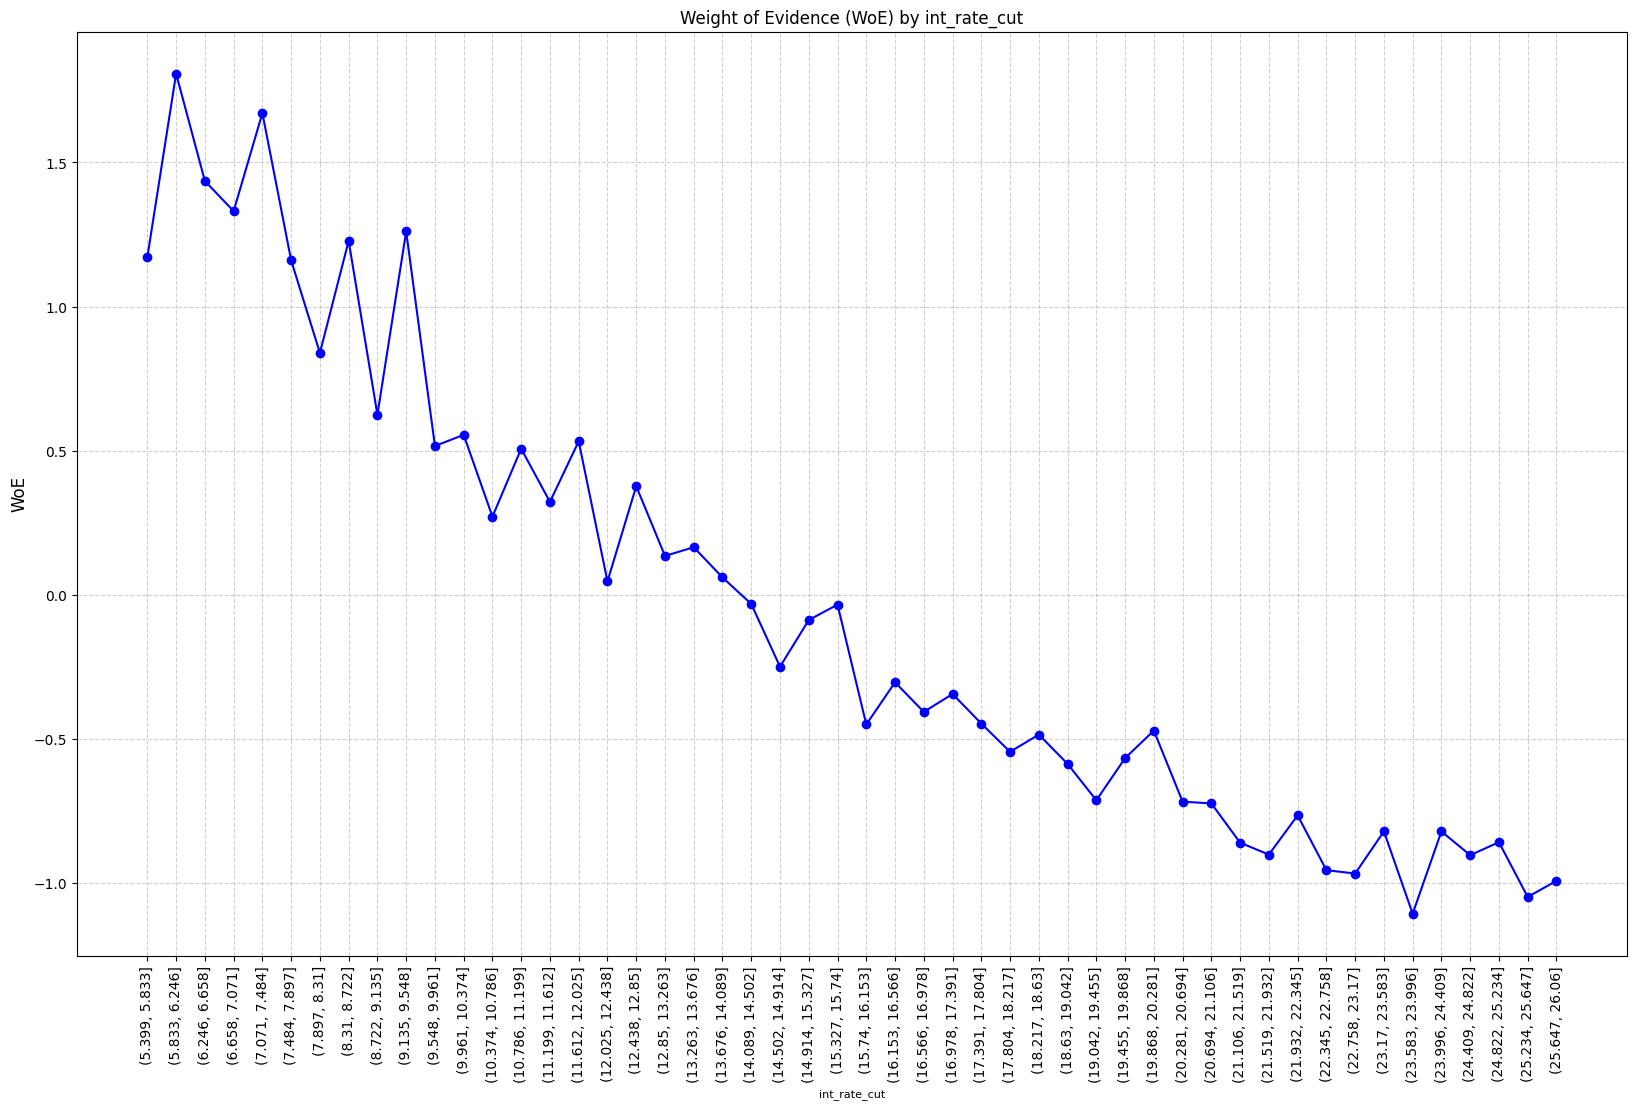

In [59]:
plot_WoE(df1, "int_rate_cut", 90)

In [392]:
df["int_rate:<9.9"] = np.where(df["mths_since_issue_d"] < 9.9 , 1, 0)
X["int_rate:<9.9,14.5)"] = np.where((df["mths_since_issue_d"]>=9.9) & (df["mths_since_issue_d"]<=14.5)  , 1, 0)
X["int_rate:<14.5, 15.3)"] = np.where((df["mths_since_issue_d"]>=14.5) & (df["mths_since_issue_d"]<15.3)  , 1, 0)
X["int_rate:<15.3,18.6)"] = np.where((df["mths_since_issue_d"]>=15.3) & (df["mths_since_issue_d"]<18.6)  , 1, 0)
X["int_rate:=>18.6)"] = np.where(df["mths_since_issue_d"]>=18.6, 1, 0)
#Nowe Zmienne: "int_rate_cut:_<9.9", "int_rate_cut:_<9.9,14.5)", "int_rate_cut:_<14.5, 15.3)", "int_rate_cut:_<15.3,18.6)", "int_rate_cut:_>18.6)"

In [61]:
df["total_pymnt_cut"] = pd.cut(df["total_pymnt"], 50)
df1 = Woe_continuous(df, df["good_bad"], "total_pymnt_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


total_pymnt_cut  n_obs  prob_good  prob_bad   n_good   n_bad  \
0      (-57.778, 1155.552]   5842   0.441116  0.558884   2577.0  3265.0   
1     (1155.552, 2311.103]  17310   0.671404  0.328596  11622.0  5688.0   
2     (2311.103, 3466.655]  27710   0.766222  0.233778  21232.0  6478.0   
3     (3466.655, 4622.206]  34992   0.824103  0.175897  28837.0  6155.0   
4     (4622.206, 5777.758]  38801   0.860442  0.139558  33386.0  5415.0   
5      (5777.758, 6933.31]  38088   0.884321  0.115679  33682.0  4406.0   
6      (6933.31, 8088.861]  34798   0.894850  0.105150  31139.0  3659.0   
7     (8088.861, 9244.413]  31237   0.901623  0.098377  28164.0  3073.0   
8    (9244.413, 10399.964]  27374   0.912654  0.087346  24983.0  2391.0   
9   (10399.964, 11555.516]  28477   0.929979  0.070021  26483.0  1994.0   
10  (11555.516, 12711.068]  24064   0.936129  0.063871  22527.0  1537.0   
11  (12711.068, 13866.619]  20377   0.935368  0.064632  19060.0  1317.0   
12  (13866.619, 15022.171]  16819   0.933052  0.066948  15693.0  1126.0   
13  (15022.171, 16177.722]  14898   0.941603  0.058397  14028.0   870.0   
14  (16177.722, 17333.274]  14575   0.950806  0.049194  13858.0   717.0   
15  (17333.274, 18488.826]  11754   0.956611  0.043389  11244.0   510.0   
16  (18488.826, 19644.377]   9704   0.951257  0.048743   9231.0   473.0   
17  (19644.377, 20799.929]   8526   0.957307  0.042693   8162.0   364.0   
18   (20799.929, 21955.48]   8378   0.962043  0.037957   8060.0   318.0   
19   (21955.48, 23111.032]   7487   0.971016  0.028984   7270.0   217.0   
20  (23111.032, 24266.584]   6147   0.970229  0.029771   5964.0   183.0   
21  (24266.584, 25422.135]   5132   0.969408  0.030592   4975.0   157.0   
22  (25422.135, 26577.687]   4738   0.974884  0.025116   4619.0   119.0   
23  (26577.687, 27733.238]   3933   0.969997  0.030003   3815.0   118.0   
24   (27733.238, 28888.79]   3327   0.973550  0.026450   3239.0    88.0   
25   (28888.79, 30044.342]   3027   0.982161  0.017839   2973.0    54.0   
26  (30044.342, 31199.893]   2696   0.984421  0.015579   2654.0    42.0   
27  (31199.893, 32355.445]   2239   0.978562  0.021438   2191.0    48.0   
28  (32355.445, 33510.996]   1742   0.979334  0.020666   1706.0    36.0   
29  (33510.996, 34666.548]   1511   0.982131  0.017869   1484.0    27.0   
30    (34666.548, 35822.1]   1437   0.983994  0.016006   1414.0    23.0   
31    (35822.1, 36977.651]   1395   0.982796  0.017204   1371.0    24.0   
32  (36977.651, 38133.203]   1357   0.982314  0.017686   1333.0    24.0   
33  (38133.203, 39288.754]   1237   0.989491  0.010509   1224.0    13.0   
34  (39288.754, 40444.306]   1242   0.991143  0.008857   1231.0    11.0   
35  (40444.306, 41599.858]    992   0.993952  0.006048    986.0     6.0   
36  (41599.858, 42755.409]    813   0.988930  0.011070    804.0     9.0   
37  (42755.409, 43910.961]    572   0.991259  0.008741    567.0     5.0   
38  (43910.961, 45066.512]    466   0.989270  0.010730    461.0     5.0   
39  (45066.512, 46222.064]    333   0.993994  0.006006    331.0     2.0   
40  (46222.064, 47377.615]    217   1.000000  0.000000    217.0     0.0   
41  (47377.615, 48533.167]    168   1.000000  0.000000    168.0     0.0   
42  (48533.167, 49688.719]    110   1.000000  0.000000    110.0     0.0   
43   (49688.719, 50844.27]     80   0.987500  0.012500     79.0     1.0   
44   (50844.27, 51999.822]     79   1.000000  0.000000     79.0     0.0   
45  (51999.822, 53155.373]     36   1.000000  0.000000     36.0     0.0   
46  (53155.373, 54310.925]     27   1.000000  0.000000     27.0     0.0   
47  (54310.925, 55466.477]     12   1.000000  0.000000     12.0     0.0   
48  (55466.477, 56622.028]      6   1.000000  0.000000      6.0     0.0   
49   (56622.028, 57777.58]      3   1.000000  0.000000      3.0     0.0   

       good%      bad%       WoE  
0   0.006205  0.064060 -2.334478  
1   0.027983  0.111599 -1.383303  
2   0.051122  0.127099 -0.910746  
3   0.069434  0.120762 -0.553450  
4   0.0803

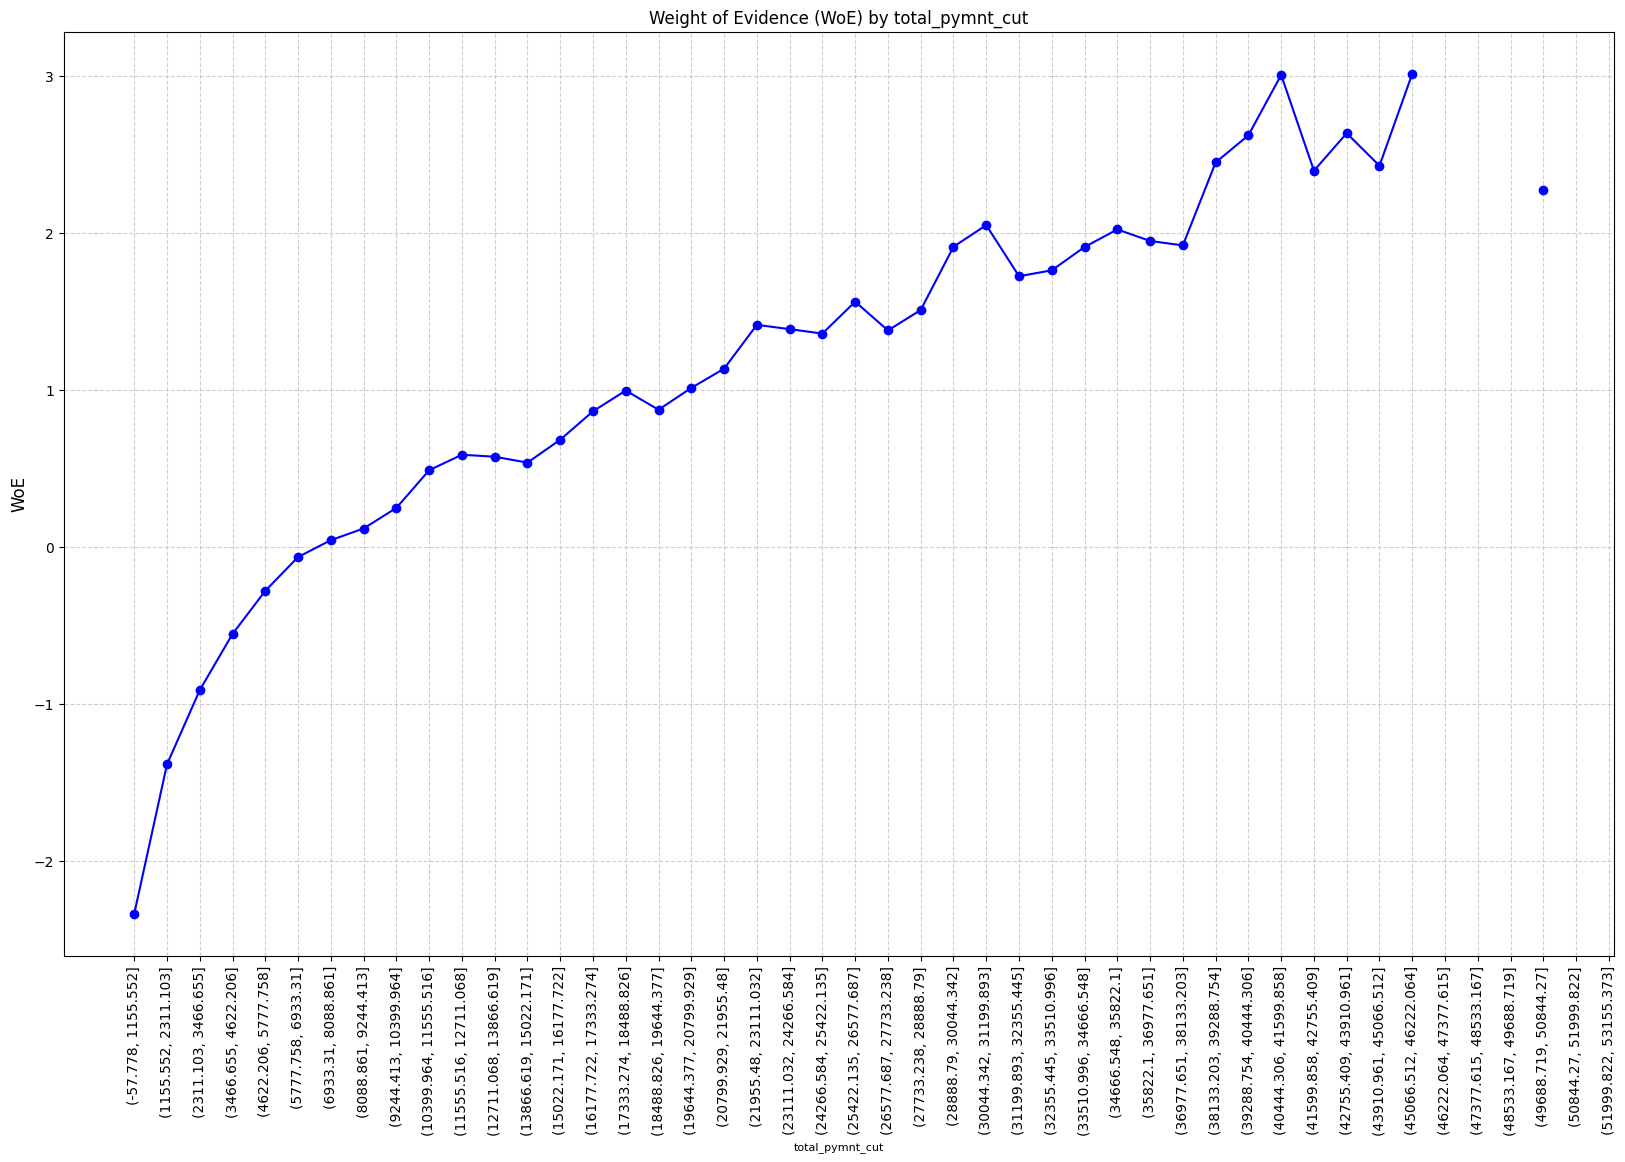

In [62]:
plot_WoE(df1, "total_pymnt_cut", 90)

In [393]:
X["total_pymnt:22K-31K"] = np.where(df['total_pymnt'].isin(range(22000,32000)),1,0)
X["total_pymnt:16K-22K"] = np.where(df['total_pymnt'].isin(range(16000,22000)),1,0)
X["total_pymnt:10K-16K"] = np.where(df['total_pymnt'].isin(range(10000,16000)),1,0)
X["total_pymnt:7K-10K"] = np.where(df['total_pymnt'].isin(range(7000,10000)),1,0)
X["total_pymnt:4.5K-7K"] = np.where(df['total_pymnt'].isin(range(4500,7000)),1,0)
X["total_pymnt:2K-4.5K"] = np.where(df['total_pymnt'].isin(range(2000,4500)),1,0)
X["total_pymnt:1K-2K"] = np.where(df['total_pymnt'].isin(range(1000,2000)),1,0)
X["total_pymnt:<1K"] = np.where(df['total_pymnt']<1000,1,0)


In [64]:
df["annual_inc_cut"] = pd.cut(df["annual_inc"], 100)

df1 = Woe_continuous(df, df["good_bad"], "annual_inc_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


annual_inc_cut   n_obs  prob_good  prob_bad    n_good    n_bad  \
0      (-5602.104, 76877.04]  306439   0.877356  0.122644  268856.0  37583.0   
1      (76877.04, 151858.08]  139400   0.914591  0.085409  127494.0  11906.0   
2     (151858.08, 226839.12]   14866   0.926880  0.073120   13779.0   1087.0   
3     (226839.12, 301820.16]    3559   0.927227  0.072773    3300.0    259.0   
4      (301820.16, 376801.2]     867   0.929642  0.070358     806.0     61.0   
5      (376801.2, 451782.24]     501   0.940120  0.059880     471.0     30.0   
6     (451782.24, 526763.28]     232   0.952586  0.047414     221.0     11.0   
7     (526763.28, 601744.32]     140   0.921429  0.078571     129.0     11.0   
8     (601744.32, 676725.36]      55   0.890909  0.109091      49.0      6.0   
9      (676725.36, 751706.4]      60   0.916667  0.083333      55.0      5.0   
10     (751706.4, 826687.44]      29   0.827586  0.172414      24.0      5.0   
11    (826687.44, 901668.48]      44   0.954545  0.045455      42.0      2.0   
12    (901668.48, 976649.52]      13   0.923077  0.076923      12.0      1.0   
13   (976649.52, 1051630.56]      20   1.000000  0.000000      20.0      0.0   
14   (1051630.56, 1126611.6]      10   1.000000  0.000000      10.0      0.0   
15   (1126611.6, 1201592.64]      11   1.000000  0.000000      11.0      0.0   
16  (1201592.64, 1276573.68]       6   0.833333  0.166667       5.0      1.0   
17  (1276573.68, 1351554.72]       4   1.000000  0.000000       4.0      0.0   
18  (1351554.72, 1426535.76]       2   1.000000  0.000000       2.0      0.0   
19   (1426535.76, 1501516.8]       4   1.000000  0.000000       4.0      0.0   
20   (1501516.8, 1576497.84]       1   1.000000  0.000000       1.0      0.0   
21  (1576497.84, 1651478.88]       1   1.000000  0.000000       1.0      0.0   
22  (1651478.88, 1726459.92]       0        NaN       NaN       NaN      NaN   
23  (1726459.92, 1801440.96]       1   1.000000  0.000000       1.0      0.0   
24   (1801440.96, 1876422.0]       0        NaN       NaN       NaN      NaN   
25   (1876422.0, 1951403.04]       2   1.000000  0.000000       2.0      0.0   
26  (1951403.04, 2026384.08]       4   1.000000  0.000000       4.0      0.0   
27  (2026384.08, 2101365.12]       1   1.000000  0.000000       1.0      0.0   
28  (2101365.12, 2176346.16]       0        NaN       NaN       NaN      NaN   
29   (2176346.16, 2251327.2]       0        NaN       NaN       NaN      NaN   
30   (2251327.2, 2326308.24]       0        NaN       NaN       NaN      NaN   
31  (2326308.24, 2401289.28]       0        NaN       NaN       NaN      NaN   
32  (2401289.28, 2476270.32]       0        NaN       NaN       NaN      NaN   
33  (2476270.32, 2551251.36]       0        NaN       NaN       NaN      NaN   
34   (2551251.36, 2626232.4]       0        NaN       NaN       NaN      NaN   
35   (2626232.4, 2701213.44]       0        NaN       NaN       NaN      NaN   
36  (2701213.44, 2776194.48]       0        NaN       NaN       NaN      NaN   
37  (2776194.48, 2851175.52]       0        NaN       NaN       NaN      NaN   
38  (2851175.52, 2926156.56]       0        NaN       NaN       NaN      NaN   
39   (2926156.56, 3001137.6]       0        NaN       NaN       NaN      NaN   
40   (3001137.6, 3076118.64]       0        NaN       NaN       NaN      NaN   
41  (3076118.64, 3151099.68]       0        NaN       NaN       NaN      NaN   
42  (3151099.68, 3226080.72]       0        NaN       NaN       NaN      NaN   
43  (3226080.72, 3301061.76]       0        NaN       NaN       NaN      NaN   
44   (3301061.76, 3376042.8]       0        NaN       NaN       NaN      NaN   
45   (3376042.8, 3451023.84]       0        NaN       NaN       NaN      NaN   
46  (3451023.84, 3526004.88]       0        NaN       NaN       NaN      NaN   
47  (3526004.88, 3600985.92]       0        NaN       NaN       NaN      NaN   
48  (3600985.92, 3675966.96]       0        NaN       NaN       NaN      NaN   
49   (3675966.

In [65]:
df["annual_inc_cut_140"] = pd.cut(df.loc[df["annual_inc"] < 140000, "annual_inc"], 50)
df1

annual_inc_cut   n_obs  prob_good  prob_bad    n_good    n_bad  \
0      (-5602.104, 76877.04]  306439   0.877356  0.122644  268856.0  37583.0   
1      (76877.04, 151858.08]  139400   0.914591  0.085409  127494.0  11906.0   
2     (151858.08, 226839.12]   14866   0.926880  0.073120   13779.0   1087.0   
3     (226839.12, 301820.16]    3559   0.927227  0.072773    3300.0    259.0   
4      (301820.16, 376801.2]     867   0.929642  0.070358     806.0     61.0   
5      (376801.2, 451782.24]     501   0.940120  0.059880     471.0     30.0   
6     (451782.24, 526763.28]     232   0.952586  0.047414     221.0     11.0   
7     (526763.28, 601744.32]     140   0.921429  0.078571     129.0     11.0   
8     (601744.32, 676725.36]      55   0.890909  0.109091      49.0      6.0   
9      (676725.36, 751706.4]      60   0.916667  0.083333      55.0      5.0   
10     (751706.4, 826687.44]      29   0.827586  0.172414      24.0      5.0   
11    (826687.44, 901668.48]      44   0.954545  0.045455      42.0      2.0   
12    (901668.48, 976649.52]      13   0.923077  0.076923      12.0      1.0   
13   (976649.52, 1051630.56]      20   1.000000  0.000000      20.0      0.0   
14   (1051630.56, 1126611.6]      10   1.000000  0.000000      10.0      0.0   
15   (1126611.6, 1201592.64]      11   1.000000  0.000000      11.0      0.0   
16  (1201592.64, 1276573.68]       6   0.833333  0.166667       5.0      1.0   
17  (1276573.68, 1351554.72]       4   1.000000  0.000000       4.0      0.0   
18  (1351554.72, 1426535.76]       2   1.000000  0.000000       2.0      0.0   
19   (1426535.76, 1501516.8]       4   1.000000  0.000000       4.0      0.0   
20   (1501516.8, 1576497.84]       1   1.000000  0.000000       1.0      0.0   
21  (1576497.84, 1651478.88]       1   1.000000  0.000000       1.0      0.0   
22  (1651478.88, 1726459.92]       0        NaN       NaN       NaN      NaN   
23  (1726459.92, 1801440.96]       1   1.000000  0.000000       1.0      0.0   
24   (1801440.96, 1876422.0]       0        NaN       NaN       NaN      NaN   
25   (1876422.0, 1951403.04]       2   1.000000  0.000000       2.0      0.0   
26  (1951403.04, 2026384.08]       4   1.000000  0.000000       4.0      0.0   
27  (2026384.08, 2101365.12]       1   1.000000  0.000000       1.0      0.0   
28  (2101365.12, 2176346.16]       0        NaN       NaN       NaN      NaN   
29   (2176346.16, 2251327.2]       0        NaN       NaN       NaN      NaN   
30   (2251327.2, 2326308.24]       0        NaN       NaN       NaN      NaN   
31  (2326308.24, 2401289.28]       0        NaN       NaN       NaN      NaN   
32  (2401289.28, 2476270.32]       0        NaN       NaN       NaN      NaN   
33  (2476270.32, 2551251.36]       0        NaN       NaN       NaN      NaN   
34   (2551251.36, 2626232.4]       0        NaN       NaN       NaN      NaN   
35   (2626232.4, 2701213.44]       0        NaN       NaN       NaN      NaN   
36  (2701213.44, 2776194.48]       0        NaN       NaN       NaN      NaN   
37  (2776194.48, 2851175.52]       0        NaN       NaN       NaN      NaN   
38  (2851175.52, 2926156.56]       0        NaN       NaN       NaN      NaN   
39   (2926156.56, 3001137.6]       0        NaN       NaN       NaN      NaN   
40   (3001137.6, 3076118.64]       0        NaN       NaN       NaN      NaN   
41  (3076118.64, 3151099.68]       0        NaN       NaN       NaN      NaN   
42  (3151099.68, 3226080.72]       0        NaN       NaN       NaN      NaN   
43  (3226080.72, 3301061.76]       0        NaN       NaN       NaN      NaN   
44   (3301061.76, 3376042.8]       0        NaN       NaN       NaN      NaN   
45   (3376042.8, 3451023.84]       0        NaN       NaN       NaN      NaN   
46  (3451023.84, 3526004.88]       0        NaN       NaN       NaN      NaN   
47  (3526004.88, 3600985.92]       0        NaN       NaN       NaN      NaN   
48  (3600985.92, 3675966.96]       0        NaN       NaN       NaN      NaN   
49   (3675966.

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


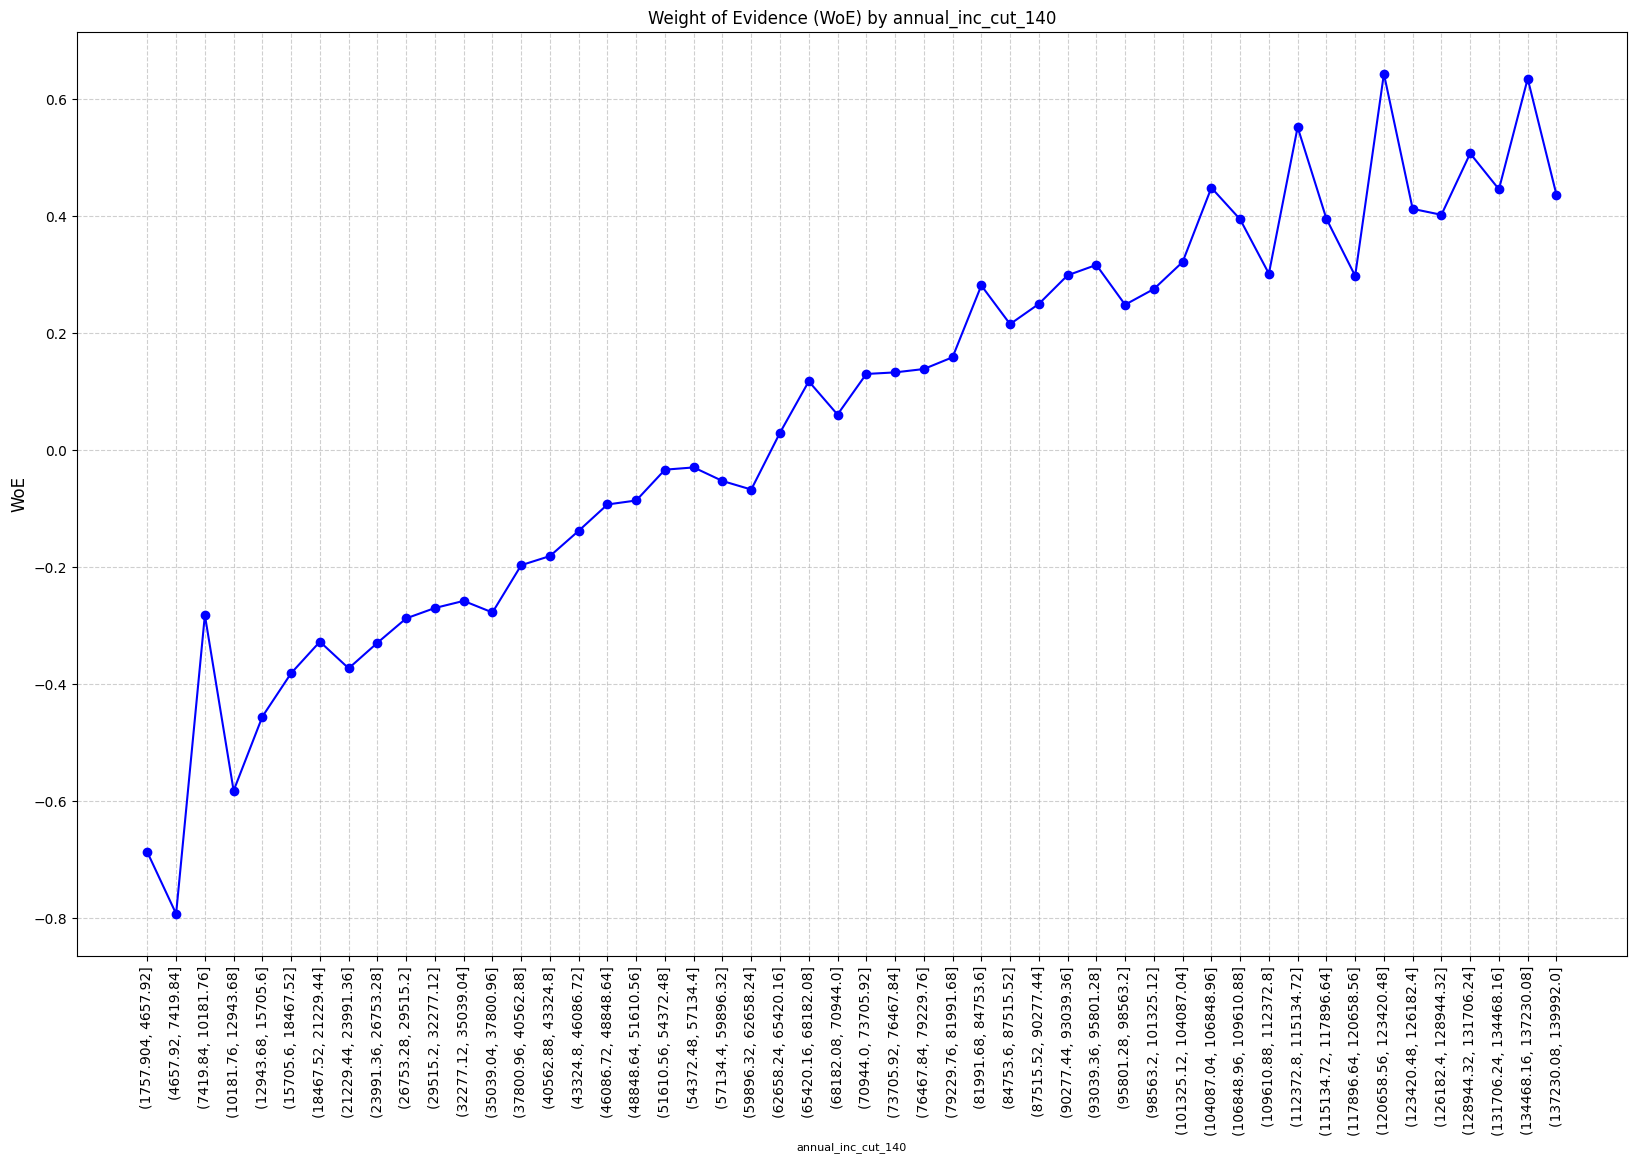

In [324]:

df1 = Woe_continuous(df, df["good_bad"], "annual_inc_cut_140")
df1
plot_WoE(df1, "annual_inc_cut_140", 90)

In [394]:
df["annual_inc:<37800"] = np.where(df["annual_inc"] < 37800, 1, 0)
X["annual_inc:<37800,40000)"] = np.where(df["annual_inc"].isin(range(37800, 40000)), 1, 0)
X["annual_inc:<40000, 46000)"] = np.where(df["annual_inc"].isin(range(40000, 46000)), 1, 0)
X["annual_inc:<46000, 60000)"] = np.where(df["annual_inc"].isin(range(46000, 60000)), 1, 0)
X["annual_inc:<60000, 65000)"] = np.where(df["annual_inc"].isin(range(60000, 65000)), 1, 0)
X["annual_inc:<65000, 90000)"] = np.where(df["annual_inc"].isin(range(65000, 90000)), 1, 0)
X["annual_inc:<90000, 140000)"] = np.where(df["annual_inc"].isin(range(90000, 140000)), 1, 0)
X["annual_inc:>=140000"] = np.where(df["annual_inc"] >= 140000, 1, 0)
# NOwe zmienne: "annual_inc_cut:<37800", "annual_inc_cut:<37800,40000)", "annual_inc_cut:<40000, 46000)", "annual_inc_cut:<46000, 60000)", "annual_inc_cut:<60000, 65000)","annual_inc_cut:<65000, 90000)", "annual_inc_cut:<90000, 140000)", "annual_inc_cut:>=140000" 

In [68]:
df["dti_cut"] = pd.cut(df["dti"], 50)
df1 = Woe_continuous(df, df["good_bad"],"dti_cut")
df1


C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


dti_cut  n_obs  prob_good  prob_bad   n_good   n_bad     good%  \
0       (-0.04, 0.8]   1924   0.896570  0.103430   1725.0   199.0  0.004153   
1         (0.8, 1.6]   2443   0.897257  0.102743   2192.0   251.0  0.005278   
2       (1.6, 2.399]   3148   0.908831  0.091169   2861.0   287.0  0.006889   
3     (2.399, 3.199]   4042   0.910440  0.089560   3680.0   362.0  0.008861   
4     (3.199, 3.999]   5171   0.909689  0.090311   4704.0   467.0  0.011326   
5     (3.999, 4.799]   6297   0.916309  0.083691   5770.0   527.0  0.013893   
6     (4.799, 5.599]   7516   0.911921  0.088079   6854.0   662.0  0.016503   
7     (5.599, 6.398]   8511   0.912936  0.087064   7770.0   741.0  0.018709   
8     (6.398, 7.198]   9664   0.914735  0.085265   8840.0   824.0  0.021285   
9     (7.198, 7.998]  10974   0.914161  0.085839  10032.0   942.0  0.024155   
10    (7.998, 8.798]  11871   0.911044  0.088956  10815.0  1056.0  0.026040   
11    (8.798, 9.598]  12910   0.907514  0.092486  11716.0  1194.0  0.028210   
12   (9.598, 10.397]  13892   0.909084  0.090916  12629.0  1263.0  0.030408   
13  (10.397, 11.197]  15016   0.903703  0.096297  13570.0  1446.0  0.032674   
14  (11.197, 11.997]  15622   0.906542  0.093458  14162.0  1460.0  0.034099   
15  (11.997, 12.797]  16572   0.901762  0.098238  14944.0  1628.0  0.035982   
16  (12.797, 13.597]  16767   0.903262  0.096738  15145.0  1622.0  0.036466   
17  (13.597, 14.396]  17140   0.898658  0.101342  15403.0  1737.0  0.037087   
18  (14.396, 15.196]  17573   0.900757  0.099243  15829.0  1744.0  0.038113   
19  (15.196, 15.996]  17317   0.897962  0.102038  15550.0  1767.0  0.037441   
20  (15.996, 16.796]  17077   0.894712  0.105288  15279.0  1798.0  0.036789   
21  (16.796, 17.596]  17188   0.887945  0.112055  15262.0  1926.0  0.036748   
22  (17.596, 18.395]  16957   0.888483  0.111517  15066.0  1891.0  0.036276   
23  (18.395, 19.195]  16475   0.886616  0.113384  14607.0  1868.0  0.035171   
24  (19.195, 19.995]  16392   0.883968  0.116032  14490.0  1902.0  0.034889   
25  (19.995, 20.795]  15603   0.881946  0.118054  13761.0  1842.0  0.033134   
26  (20.795, 21.595]  14862   0.878684  0.121316  13059.0  1803.0  0.031443   
27  (21.595, 22.394]  14149   0.875680  0.124320  12390.0  1759.0  0.029833   
28  (22.394, 23.194]  13650   0.872821  0.127179  11914.0  1736.0  0.028687   
29  (23.194, 23.994]  12794   0.875020  0.124980  11195.0  1599.0  0.026955   
30  (23.994, 24.794]  12251   0.869807  0.130193  10656.0  1595.0  0.025658   
31  (24.794, 25.594]  10672   0.874063  0.125937   9328.0  1344.0  0.022460   
32  (25.594, 26.393]   9734   0.873639  0.126361   8504.0  1230.0  0.020476   
33  (26.393, 27.193]   9036   0.868526  0.131474   7848.0  1188.0  0.018896   
34  (27.193, 27.993]   8380   0.866826  0.133174   7264.0  1116.0  0.017490   
35  (27.993, 28.793]   7936   0.866935  0.133065   6880.0  1056.0  0.016566   
36  (28.793, 29.593]   7277   0.868765  0.131235   6322.0   955.0  0.015222   
37  (29.593, 30.392]   5908   0.863913  0.136087   5104.0   804.0  0.012289   
38  (30.392, 31.192]   4783   0.863266  0.136734   4129.0   654.0  0.009942   
39  (31.192, 31.992]   4384   0.868841  0.131159   3809.0   575.0  0.009171   
40  (31.992, 32.792]   3838   0.859562  0.140438   3299.0   539.0  0.007943   
41  (32.792, 33.592]   3529   0.867951  0.132049   3063.0   466.0  0.007375   
42  (33.592, 34.391]   3296   0.866201  0.133799   2855.0   441.0  0.006874   
43  (34.391, 35.191]   2313   0.862516  0.137484   1995.0   318.0  0.004804   
44  (35.191, 35.991]    678   0.902655  0.097345    612.0    66.0  0.001474   
45  (35.991, 36.791]    674   0.878338  0.121662    592.0    82.0  0.001425   
46  (36.791, 37.591]    601   0.888519  0.111481    534.0    67.0  0.001286   
47   (37.591, 38.39]    541   0.885397  0.114603    479.0    62.0  0.001153   
48    (38.39, 39.19]    467   0.869379  0.130621    406.0    61.0  0.000978   
49    (39.19, 39.99]    470   0.902128  0.097872    424.0    46

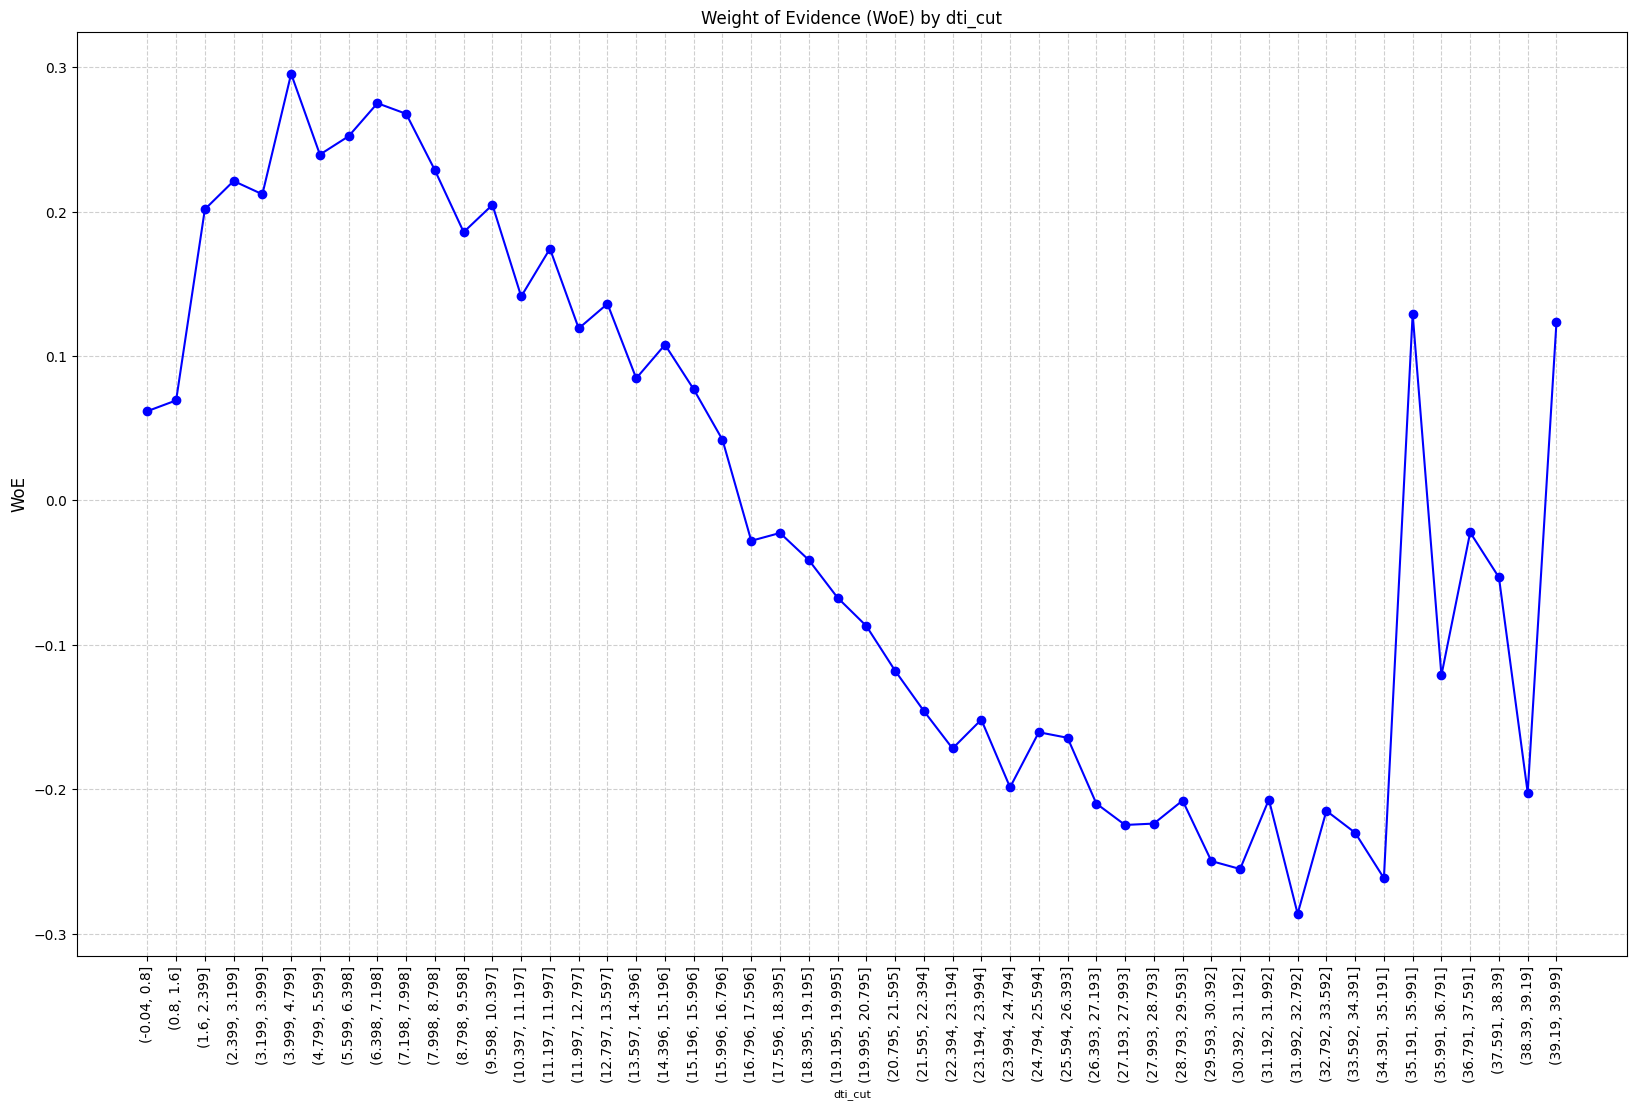

In [69]:
plot_WoE(df1, "dti_cut", 90)

In [395]:
X["dti:<8"] = np.where(df["dti"] < 8 , 1, 0 )
X["dti:<8,15)"] = np.where(df["dti"].isin(range(8,15)), 1, 0)
X["dti:<15,22)"] = np.where(df["dti"].isin(range(15,22)), 1, 0)
X["dti:<22,28)"] = np.where(df["dti"].isin(range(22,28)), 1, 0)
df["dti:>=28"] = np.where(df["dti"] > 28 , 1, 0 )

#Nowe Zmienne: "dti:<8", "dti:<8,15)", "dti:<8,15)", "dti:<15,22)", "dti:<22,28)", "dti:>=28"

In [396]:
X.columns

Index(['addr_state:_NE_NV_HI_AL', 'addr_state:_ME_DC_IA_WY_WV',
       'addr_state:_LA_OK_NM_NC', 'addr_state:_NJ_VA_MD_MO',
       'addr_state:_KS_MT_CO_SC', 'addr_state:_CT_IL',
       'addr_state:_WI_OR_WA_GA', 'addr_state:_MA_DE_IN',
       'addr_state:_KY_SD_MN', 'addr_state:_TN_AZ_UT_MI',
       'addr_state:_OH_PA_RI_AR', 'addr_state:_TX', 'addr_state:_NY',
       'addr_state:_CA', 'addr_state:_FL', 'home_ownership:_MORTGAGE',
       'home_ownership:_OWN', 'verification_status:_Source Verified',
       'verification_status:_Verified', 'grade:A', 'grade:B', 'grade:C',
       'grade:D', 'grade:E', 'grade:F', 'purpose:renewable_energy_&_moving',
       'purpose:house_other_medical', 'purpose:wedding_vacation',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'initial_list_status:f', 'term:36', 'emp_length:1-4', 'emp_length:5-6',
       'emp_length:7-9', 'emp_length:10', 'mths_since_issue_d:<64,84)',
       'mths_since_issue_d:<54,64)', 'mths_since_issue_d:<51,54)',

In [71]:
df["mths_since_last_delinq"].notnull().sum()
df_not_null = df[pd.notnull(df["mths_since_last_delinq"])]
df_not_null["mths_since_last_delinq_cut"] = pd.cut(df_not_null["mths_since_last_delinq"], 50)
df1 = Woe_continuous(df_not_null, df_not_null["good_bad"], "mths_since_last_delinq_cut")
df1 

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\240821218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_null["mths_since_last_delinq_cut"] = pd.cut(df_not_null["mths_since_last_delinq"], 50)
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed

mths_since_last_delinq_cut  n_obs  prob_good  prob_bad   n_good   n_bad  \
0              (-0.188, 3.76]   6625   0.870943  0.129057   5770.0   855.0   
1                (3.76, 7.52]  13834   0.886801  0.113199  12268.0  1566.0   
2               (7.52, 11.28]  16690   0.892331  0.107669  14893.0  1797.0   
3              (11.28, 15.04]  16547   0.888076  0.111924  14695.0  1852.0   
4               (15.04, 18.8]  11645   0.894805  0.105195  10420.0  1225.0   
5               (18.8, 22.56]  14579   0.892997  0.107003  13019.0  1560.0   
6              (22.56, 26.32]  13603   0.896052  0.103948  12189.0  1414.0   
7              (26.32, 30.08]  13221   0.895318  0.104682  11837.0  1384.0   
8              (30.08, 33.84]   9442   0.899492  0.100508   8493.0   949.0   
9               (33.84, 37.6]  12168   0.898669  0.101331  10935.0  1233.0   
10              (37.6, 41.36]  11680   0.890411  0.109589  10400.0  1280.0   
11             (41.36, 45.12]  11494   0.894119  0.105881  10277.0  1217.0   
12             (45.12, 48.88]   8148   0.896784  0.103216   7307.0   841.0   
13             (48.88, 52.64]   8091   0.889260  0.110740   7195.0   896.0   
14              (52.64, 56.4]   7563   0.893825  0.106175   6760.0   803.0   
15              (56.4, 60.16]   7316   0.901449  0.098551   6595.0   721.0   
16             (60.16, 63.92]   5076   0.886525  0.113475   4500.0   576.0   
17             (63.92, 67.68]   6618   0.892415  0.107585   5906.0   712.0   
18             (67.68, 71.44]   6435   0.889666  0.110334   5725.0   710.0   
19              (71.44, 75.2]   6157   0.888907  0.111093   5473.0   684.0   
20              (75.2, 78.96]   4228   0.893567  0.106433   3778.0   450.0   
21             (78.96, 82.72]   4460   0.884978  0.115022   3947.0   513.0   
22             (82.72, 86.48]    118   0.796610  0.203390     94.0    24.0   
23             (86.48, 90.24]     46   0.913043  0.086957     42.0     4.0   
24              (90.24, 94.0]     32   0.937500  0.062500     30.0     2.0   
25              (94.0, 97.76]     25   0.760000  0.240000     19.0     6.0   
26            (97.76, 101.52]     17   0.941176  0.058824     16.0     1.0   
27           (101.52, 105.28]     13   0.923077  0.076923     12.0     1.0   
28           (105.28, 109.04]     11   0.818182  0.181818      9.0     2.0   
29            (109.04, 112.8]      3   0.666667  0.333333      2.0     1.0   
30            (112.8, 116.56]      8   0.875000  0.125000      7.0     1.0   
31           (116.56, 120.32]      4   1.000000  0.000000      4.0     0.0   
32           (120.32, 124.08]      4   1.000000  0.000000      4.0     0.0   
33           (124.08, 127.84]      2   1.000000  0.000000      2.0     0.0   
34            (127.84, 131.6]      6   1.000000  0.000000      6.0     0.0   
35            (131.6, 135.36]      8   0.750000  0.250000      6.0     2.0   
36           (135.36, 139.12]      2   1.000000  0.000000      2.0     0.0   
37           (139.12, 142.88]      3   1.000000  0.000000      3.0     0.0   
38           (142.88, 146.64]      2   1.000000  0.000000      2.0     0.0   
39            (146.64, 150.4]      3   0.666667  0.333333      2.0     1.0   
40            (150.4, 154.16]      2   0.500000  0.500000      1.0     1.0   
41           (154.16, 157.92]      1   1.000000  0.000000      1.0     0.0   
42           (157.92, 161.68]      1   1.000000  0.000000      1.0     0.0   
43           (161.68, 165.44]      0        NaN       NaN      NaN     NaN   
44            (165.44, 169.2]      0        NaN       NaN      NaN     NaN   
45            (169.2, 172.96]      1   1.000000  0.000000      1.0     0.0   
46           (172.96, 176.72]      0        NaN       NaN      NaN     NaN   
47           (176.72, 180.48]      1   1.000000  0.000000      1.0     0.0   
48           (180.48, 184.24]      0        NaN       NaN      NaN     NaN   
49            (184.24, 188.0]      1   1.000000  0.000000      1.0     0.0   

       good%      bad%  

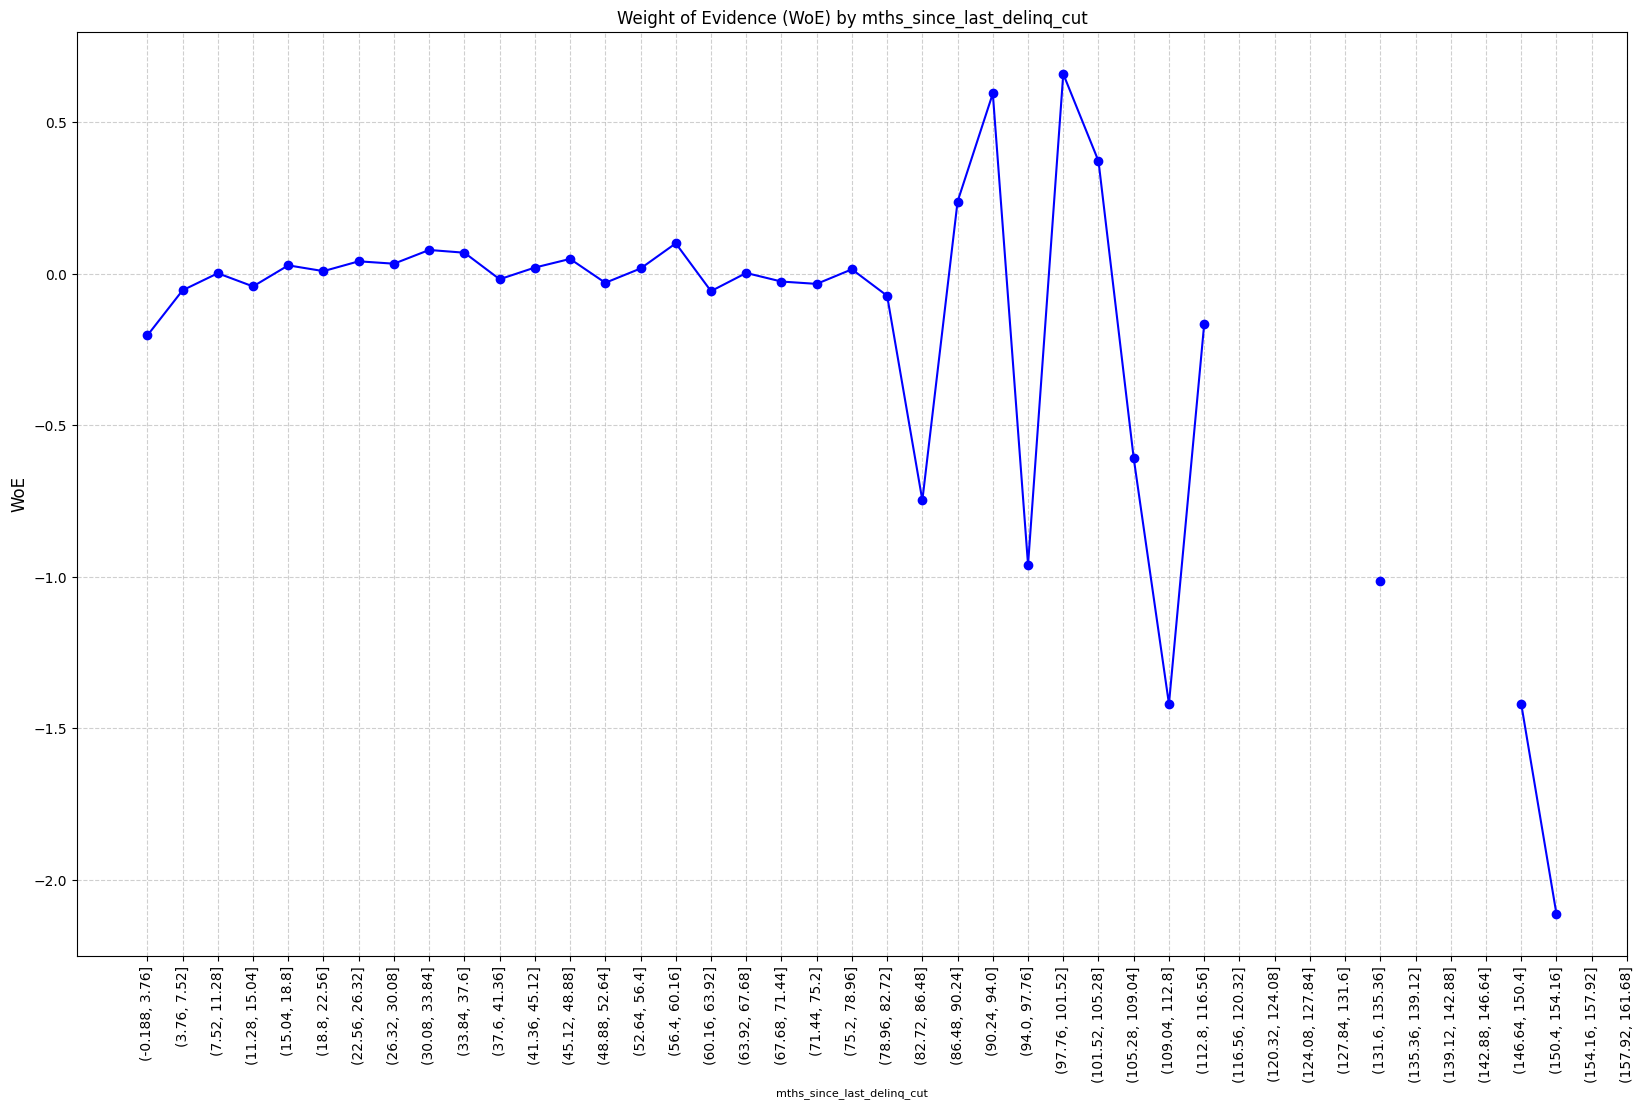

In [72]:
plot_WoE(df1, "mths_since_last_delinq_cut", 90)

In [429]:
X["mths_since_last_delinq:misssing"] = np.where(df["mths_since_last_delinq"].isnull(), 1 , 0 )
X["mths_since_last_delinq:<19"] = np.where(df["mths_since_last_delinq"] < 19, 1, 0) 
X["mths_since_last_delinq:<19,37.5)"] = np.where(df["mths_since_last_delinq"].isin(range(19,37)), 1, 0)
X["mths_since_last_delinq:<37.5, 60)"] = np.where(df["mths_since_last_delinq"].isin(range(37, 60)), 1, 0)
df["mths_since_last_delinq:>=60"] = np.where(df["mths_since_last_delinq"] >= 60, 1, 0) 
# Nowe Zmienne: "mths_since_last_delinq_misssing", "mths_since_last_delinq:_<19", "mths_since_last_delinq:_<19,37.5)", "mths_since_last_delinq:_<37.5, 60)", "mths_since_last_delinq:_>=60"

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\2325527934.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["mths_since_last_delinq:misssing"] = np.where(df["mths_since_last_delinq"].isnull(), 1 , 0 )
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\2325527934.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["mths_since_last_delinq:<19"] = np.where(df["mths_since_last_delinq"] < 19, 1, 0)
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\2325527934.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usua

In [430]:
Woe_discrit(df, df["good_bad"], "acc_now_delinq")
X["acc_now_delinq:0"] = np.where(df["acc_now_delinq"] == 0, 1, 0)

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3720352522.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["acc_now_delinq:0"] = np.where(df["acc_now_delinq"] == 0, 1, 0)


In [75]:
df["installment_cut"] = pd.cut(df["installment"], 50)  
df1 = Woe_continuous(df, df["good_bad"], "installment_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)


installment_cut  n_obs  prob_good  prob_bad   n_good   n_bad  \
0       (14.276, 43.556]   2297   0.898999  0.101001   2065.0   232.0   
1       (43.556, 71.443]   6090   0.898851  0.101149   5474.0   616.0   
2       (71.443, 99.329]   8554   0.893617  0.106383   7644.0   910.0   
3      (99.329, 127.216]  11440   0.891434  0.108566  10198.0  1242.0   
4     (127.216, 155.102]  12648   0.894450  0.105550  11313.0  1335.0   
5     (155.102, 182.988]  20953   0.894908  0.105092  18751.0  2202.0   
6     (182.988, 210.875]  21342   0.904836  0.095164  19311.0  2031.0   
7     (210.875, 238.761]  18804   0.900606  0.099394  16935.0  1869.0   
8     (238.761, 266.648]  23532   0.901028  0.098972  21203.0  2329.0   
9     (266.648, 294.534]  25075   0.890728  0.109272  22335.0  2740.0   
10     (294.534, 322.42]  25573   0.898213  0.101787  22970.0  2603.0   
11     (322.42, 350.307]  31943   0.889929  0.110071  28427.0  3516.0   
12    (350.307, 378.193]  23771   0.884691  0.115309  21030.0  2741.0   
13     (378.193, 406.08]  22416   0.895298  0.104702  20069.0  2347.0   
14     (406.08, 433.966]  16780   0.879976  0.120024  14766.0  2014.0   
15    (433.966, 461.852]  15802   0.882420  0.117580  13944.0  1858.0   
16    (461.852, 489.739]  19658   0.893224  0.106776  17559.0  2099.0   
17    (489.739, 517.625]  19494   0.890890  0.109110  17367.0  2127.0   
18    (517.625, 545.512]  13400   0.864179  0.135821  11580.0  1820.0   
19    (545.512, 573.398]  13179   0.878443  0.121557  11577.0  1602.0   
20    (573.398, 601.284]  11849   0.878133  0.121867  10405.0  1444.0   
21    (601.284, 629.171]  11674   0.905260  0.094740  10568.0  1106.0   
22    (629.171, 657.057]  10466   0.897764  0.102236   9396.0  1070.0   
23    (657.057, 684.944]  11484   0.892024  0.107976  10244.0  1240.0   
24     (684.944, 712.83]   7726   0.877686  0.122314   6781.0   945.0   
25     (712.83, 740.716]   6081   0.885710  0.114290   5386.0   695.0   
26    (740.716, 768.603]   6604   0.894761  0.105239   5909.0   695.0   
27    (768.603, 796.489]   6150   0.900163  0.099837   5536.0   614.0   
28    (796.489, 824.376]   5052   0.889549  0.110451   4494.0   558.0   
29    (824.376, 852.262]   4605   0.886862  0.113138   4084.0   521.0   
30    (852.262, 880.148]   5270   0.891651  0.108349   4699.0   571.0   
31    (880.148, 908.035]   3999   0.871468  0.128532   3485.0   514.0   
32    (908.035, 935.921]   2753   0.868870  0.131130   2392.0   361.0   
33    (935.921, 963.808]   3059   0.873815  0.126185   2673.0   386.0   
34    (963.808, 991.694]   2227   0.837000  0.163000   1864.0   363.0   
35    (991.694, 1019.58]   2056   0.857004  0.142996   1762.0   294.0   
36   (1019.58, 1047.467]   1574   0.871665  0.128335   1372.0   202.0   
37  (1047.467, 1075.353]   1098   0.886157  0.113843    973.0   125.0   
38   (1075.353, 1103.24]   1304   0.923313  0.076687   1204.0   100.0   
39   (1103.24, 1131.126]   1040   0.922115  0.077885    959.0    81.0   
40  (1131.126, 1159.012]   1218   0.920361  0.079639   1121.0    97.0   
41  (1159.012, 1186.899]   1475   0.913898  0.086102   1348.0   127.0   
42  (1186.899, 1214.785]   1571   0.902610  0.097390   1418.0   153.0   
43  (1214.785, 1242.672]   1264   0.891614  0.108386   1127.0   137.0   
44  (1242.672, 1270.558]    897   0.860647  0.139353    772.0   125.0   
45  (1270.558, 1298.444]    561   0.827094  0.172906    464.0    97.0   
46  (1298.444, 1326.331]    236   0.762712  0.237288    180.0    56.0   
47  (1326.331, 1354.217]    147   0.761905  0.238095    112.0    35.0   
48  (1354.217, 1382.104]     51   0.686275  0.313725     35.0    16.0   
49   (1382.104, 1409.99]     43   0.837209  0.162791     36.0     7.0   

       good%      bad%       WoE  
0   0.004972  0.004552  0.088304  
1   0.013180  0.012086  0.086674  
2   0.018405  0.017854  0.030388  
3   0.024555  0.024368  0.007625  
4   0.027239  0.026193  0.039177  
5   0.045149  0.043204  0.044037  
6   0.046497  0.039849  0.154302  
7   0

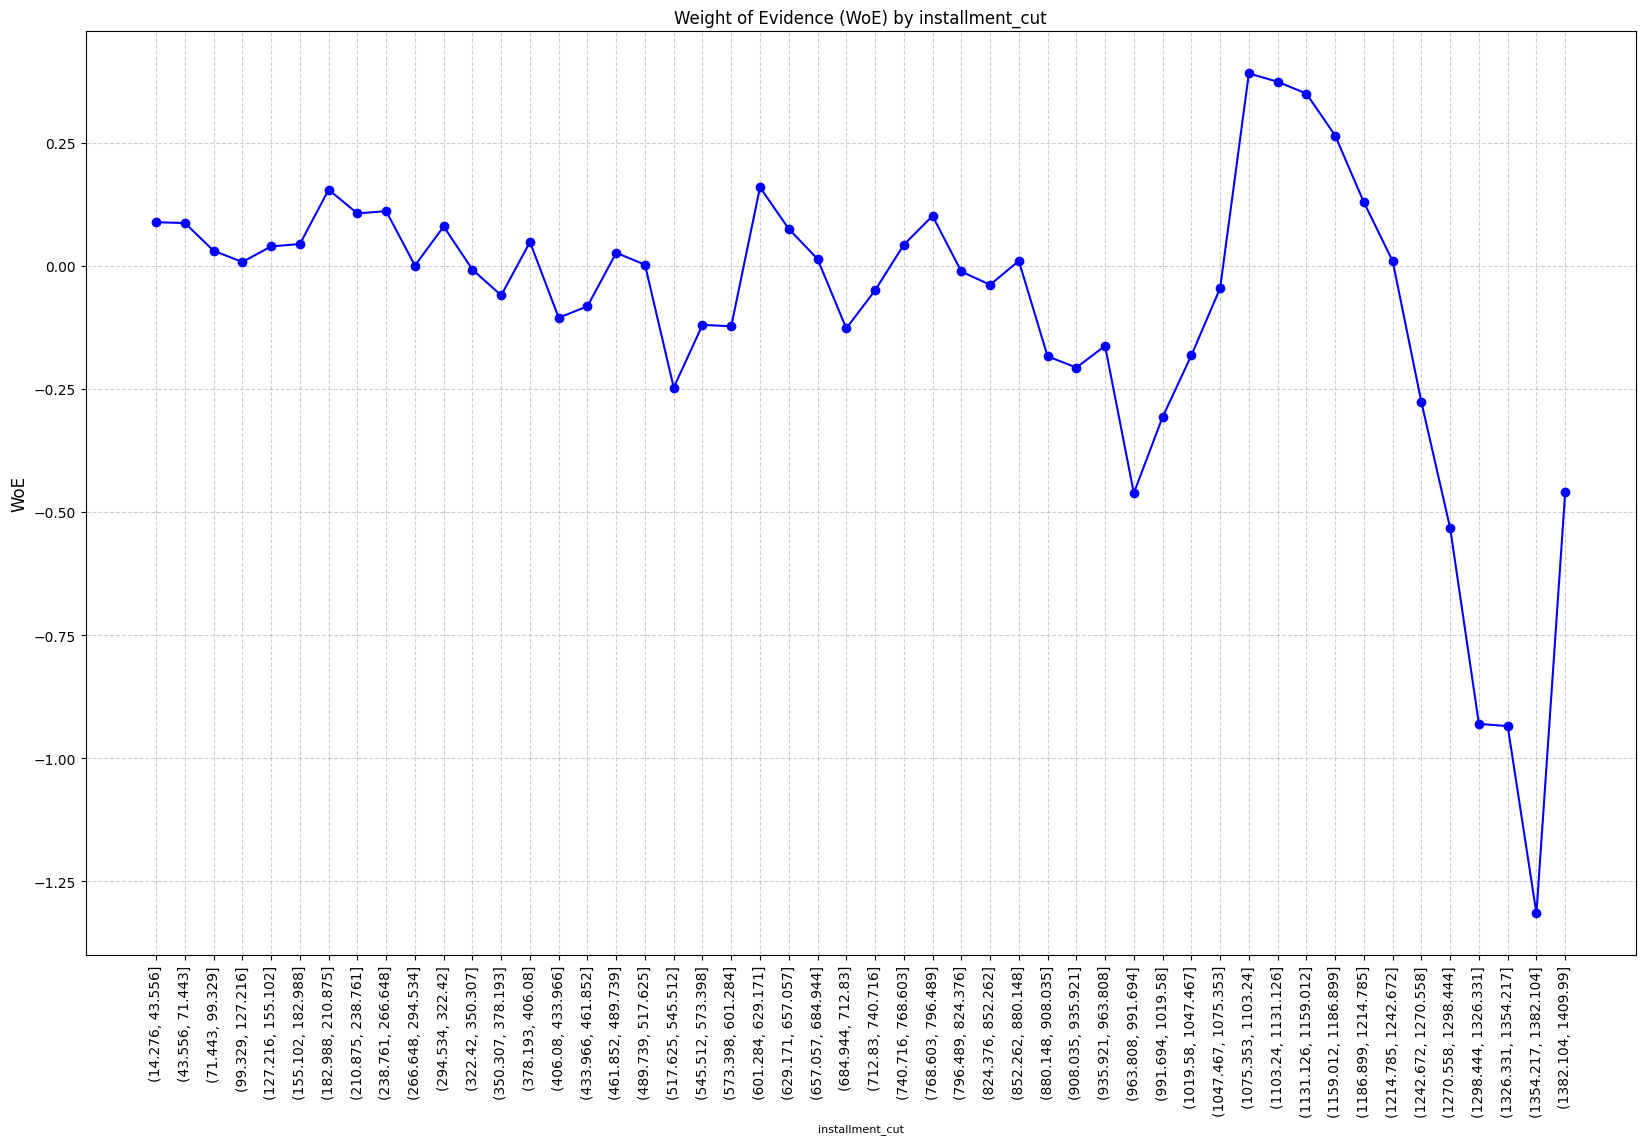

In [76]:
plot_WoE(df1, "installment_cut", 90)

In [399]:
X["installment:>963"] = np.where(df["installment"] >= 963, 1, 0)
X["installment:<880,963)"] = np.where(df["installment"].isin(range(880,963)), 1, 0)
X["installment:<684,880)"] = np.where(df["installment"].isin(range(684,880)), 1, 0)
X["installment:<573,684)"] = np.where(df["installment"].isin(range(573,684)), 1, 0)
X["installment:<489,573)"] = np.where(df["installment"].isin(range(489,573)), 1, 0)
X["installment:<322,489)"] = np.where(df["installment"].isin(range(322,489)), 1, 0)
X["installment:<182,322)"] = np.where(df["installment"].isin(range(182,322)), 1, 0)
df["installment:<182"] = np.where(df["installment"] < 182, 1, 0)

In [78]:
Woe_continuous(df,df["good_bad"],"delinq_2yrs") 

delinq_2yrs   n_obs  prob_good  prob_bad    n_good    n_bad     good%  \
0           0.0  382983   0.890588  0.109412  341080.0  41903.0  0.821252   
1           1.0   56224   0.892679  0.107321   50190.0   6034.0  0.120847   
2           2.0   16310   0.888228  0.111772   14487.0   1823.0  0.034882   
3           3.0    5684   0.885292  0.114708    5032.0    652.0  0.012116   
4           4.0    2378   0.896131  0.103869    2131.0    247.0  0.005131   
5           5.0    1236   0.888350  0.111650    1098.0    138.0  0.002644   
6           6.0     629   0.893482  0.106518     562.0     67.0  0.001353   
7           7.0     346   0.872832  0.127168     302.0     44.0  0.000727   
8           8.0     177   0.903955  0.096045     160.0     17.0  0.000385   
9           9.0     111   0.900901  0.099099     100.0     11.0  0.000241   
10         10.0      65   0.861538  0.138462      56.0      9.0  0.000135   
11         11.0      41   0.926829  0.073171      38.0      3.0  0.000091   
12         12.0      38   0.710526  0.289474      27.0     11.0  0.000065   
13         13.0      25   0.840000  0.160000      21.0      4.0  0.000051   
14         14.0       8   0.875000  0.125000       7.0      1.0  0.000017   
15         15.0       7   0.857143  0.142857       6.0      1.0  0.000014   
16         16.0       5   1.000000  0.000000       5.0      0.0  0.000012   
17         17.0       3   0.666667  0.333333       2.0      1.0  0.000005   
18         18.0       6   0.833333  0.166667       5.0      1.0  0.000012   
19         19.0       3   1.000000  0.000000       3.0      0.0  0.000007   
20         21.0       2   0.500000  0.500000       1.0      1.0  0.000002   
21         22.0       2   1.000000  0.000000       2.0      0.0  0.000005   
22         24.0       1   1.000000  0.000000       1.0      0.0  0.000002   
23         29.0       1   1.000000  0.000000       1.0      0.0  0.000002   

        bad%       WoE  
0   0.822143 -0.001084  
1   0.118388  0.020562  
2   0.035768 -0.025076  
3   0.012792 -0.054316  
4   0.004846  0.057114  
5   0.002708 -0.023852  
6   0.001315  0.028965  
7   0.000863 -0.171607  
8   0.000334  0.144116  
9   0.000216  0.109431  
10  0.000177 -0.269717  
11  0.000059  0.441130  
12  0.000216 -1.199903  
13  0.000078 -0.439616  
14  0.000020 -0.151934  
15  0.000020 -0.306085  
16  0.000000       inf  
17  0.000020 -1.404697  
18  0.000020 -0.488406  
19  0.000000       inf  
20  0.000020 -2.097844  
21  0.000000       inf  
22  0.000000       inf  
23  0.000000       inf

In [400]:
X["delinq_2yrs:0"] = np.where(df["delinq_2yrs"] == 0, 1, 0)
X["delinq_2yrs:1"] = np.where(df["delinq_2yrs"] == 1, 1, 0)
X["delinq_2yrs:2"] = np.where(df["delinq_2yrs"] == 2, 1, 0)
X["delinq_2yrs:<3,4>"] = np.where(df["delinq_2yrs"].isin(range(3,5)), 1, 0)

In [401]:
X['mths_since_earliest_cr_line:141-164'] = np.where(df["month_since_earliest_cr_line"].isin(range(141,164)),1,0)
X['mths_since_earliest_cr_line:165-247'] = np.where(df["month_since_earliest_cr_line"].isin(range(165,247)),1,0)
X['mths_since_earliest_cr_line:248-270'] = np.where(df["month_since_earliest_cr_line"].isin(range(248,270)),1,0)
X['mths_since_earliest_cr_line:271-352'] = np.where(df["month_since_earliest_cr_line"].isin(range(271,252)),1,0)
X['mths_since_earliest_cr_line:>352'] = np.where(df["month_since_earliest_cr_line"] > 352,1,0)

In [80]:
Woe_continuous(df, df["good_bad"], "inq_last_6mths")

C:\Users\macko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


inq_last_6mths   n_obs  prob_good  prob_bad    n_good    n_bad     good%  \
0              0.0  241527   0.908735  0.091265  219484.0  22043.0  0.528473   
1              1.0  130148   0.884439  0.115561  115108.0  15040.0  0.277157   
2              2.0   57825   0.863606  0.136394   49938.0   7887.0  0.120241   
3              3.0   25126   0.841001  0.158999   21131.0   3995.0  0.050879   
4              4.0    7241   0.846982  0.153018    6133.0   1108.0  0.014767   
5              5.0    2768   0.828396  0.171604    2293.0    475.0  0.005521   
6              6.0    1188   0.783670  0.216330     931.0    257.0  0.002242   
7              7.0     195   0.651282  0.348718     127.0     68.0  0.000306   
8              8.0     122   0.622951  0.377049      76.0     46.0  0.000183   
9              9.0      50   0.640000  0.360000      32.0     18.0  0.000077   
10            10.0      24   0.875000  0.125000      21.0      3.0  0.000051   
11            11.0      15   0.800000  0.200000      12.0      3.0  0.000029   
12            12.0      15   0.600000  0.400000       9.0      6.0  0.000022   
13            13.0       6   0.666667  0.333333       4.0      2.0  0.000010   
14            14.0       6   0.166667  0.833333       1.0      5.0  0.000002   
15            15.0       9   0.444444  0.555556       4.0      5.0  0.000010   
16            16.0       3   1.000000  0.000000       3.0      0.0  0.000007   
17            17.0       2   0.500000  0.500000       1.0      1.0  0.000002   
18            18.0       4   0.500000  0.500000       2.0      2.0  0.000005   
19            19.0       2   1.000000  0.000000       2.0      0.0  0.000005   
20            20.0       1   0.000000  1.000000       0.0      1.0  0.000000   
21            24.0       2   1.000000  0.000000       2.0      0.0  0.000005   
22            25.0       1   0.000000  1.000000       0.0      1.0  0.000000   
23            27.0       1   1.000000  0.000000       1.0      0.0  0.000002   
24            28.0       1   1.000000  0.000000       1.0      0.0  0.000002   
25            31.0       1   1.000000  0.000000       1.0      0.0  0.000002   
26            32.0       1   0.000000  1.000000       0.0      1.0  0.000000   
27            33.0       1   0.000000  1.000000       0.0      1.0  0.000000   

        bad%       WoE  
0   0.432487  0.200440  
1   0.295087 -0.062687  
2   0.154744 -0.252278  
3   0.078383 -0.432147  
4   0.021739 -0.386717  
5   0.009320 -0.523543  
6   0.005042 -0.810661  
7   0.001334 -1.473165  
8   0.000903 -1.595752  
9   0.000353 -1.522480  
10  0.000059 -0.151934  
11  0.000059 -0.711550  
12  0.000118 -1.692379  
13  0.000039 -1.404697  
14  0.000098 -3.707282  
15  0.000098 -2.320988  
16  0.000000       inf  
17  0.000020 -2.097844  
18  0.000039 -2.097844  
19  0.000000       inf  
20  0.000020      -inf  
21  0.000000       inf  
22  0.000020      -inf  
23  0.000000       inf  
24  0.000000       inf  
25  0.000000       inf  
26  0.000020      -inf  
27  0.000020      -inf

In [402]:
X["inq_last_6mths:0"] = np.where(df["inq_last_6mths"] == 0, 1, 0)
X["inq_last_6mths:1"] = np.where(df["inq_last_6mths"] == 1, 1, 0)
X["inq_last_6mths:2"] = np.where(df["inq_last_6mths"] == 2, 1, 0)
X["inq_last_6mths:<3,4>"] = np.where(df["inq_last_6mths"].isin(range(3,5)), 1, 0)


In [82]:
df1 = Woe_continuous(df, df["good_bad"], "open_acc")
df1

C:\Users\macko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


open_acc  n_obs  prob_good  prob_bad   n_good   n_bad     good%      bad%  \
0        0.0     36   0.805556  0.194444     29.0     7.0  0.000070  0.000137   
1        1.0    142   0.873239  0.126761    124.0    18.0  0.000299  0.000353   
2        2.0   1790   0.844134  0.155866   1511.0   279.0  0.003638  0.005474   
3        3.0   5500   0.869455  0.130545   4782.0   718.0  0.011514  0.014087   
4        4.0  12588   0.891643  0.108357  11224.0  1364.0  0.027025  0.026762   
5        5.0  21544   0.891292  0.108708  19202.0  2342.0  0.046235  0.045950   
6        6.0  30837   0.892045  0.107955  27508.0  3329.0  0.066234  0.065315   
7        7.0  37602   0.890618  0.109382  33489.0  4113.0  0.080635  0.080698   
8        8.0  41893   0.891509  0.108491  37348.0  4545.0  0.089926  0.089174   
9        9.0  44019   0.889002  0.110998  39133.0  4886.0  0.094224  0.095864   
10      10.0  42512   0.889067  0.110933  37796.0  4716.0  0.091005  0.092529   
11      11.0  39112   0.887605  0.112395  34716.0  4396.0  0.083589  0.086250   
12      12.0  34585   0.888796  0.111204  30739.0  3846.0  0.074013  0.075459   
13      13.0  29806   0.895021  0.104979  26677.0  3129.0  0.064233  0.061391   
14      14.0  24730   0.890619  0.109381  22025.0  2705.0  0.053032  0.053073   
15      15.0  20234   0.891865  0.108135  18046.0  2188.0  0.043451  0.042929   
16      16.0  16809   0.894759  0.105241  15040.0  1769.0  0.036213  0.034708   
17      17.0  13392   0.890905  0.109095  11931.0  1461.0  0.028727  0.028665   
18      18.0  10865   0.896641  0.103359   9742.0  1123.0  0.023457  0.022033   
19      19.0   8647   0.892795  0.107205   7720.0   927.0  0.018588  0.018188   
20      20.0   6668   0.895021  0.104979   5968.0   700.0  0.014370  0.013734   
21      21.0   5279   0.893730  0.106270   4718.0   561.0  0.011360  0.011007   
22      22.0   4097   0.892604  0.107396   3657.0   440.0  0.008805  0.008633   
23      23.0   3158   0.901520  0.098480   2847.0   311.0  0.006855  0.006102   
24      24.0   2452   0.891109  0.108891   2185.0   267.0  0.005261  0.005239   
25      25.0   1933   0.888257  0.111743   1717.0   216.0  0.004134  0.004238   
26      26.0   1314   0.902588  0.097412   1186.0   128.0  0.002856  0.002511   
27      27.0   1067   0.903468  0.096532    964.0   103.0  0.002321  0.002021   
28      28.0    766   0.904700  0.095300    693.0    73.0  0.001669  0.001432   
29      29.0    624   0.889423  0.110577    555.0    69.0  0.001336  0.001354   
30      30.0    484   0.890496  0.109504    431.0    53.0  0.001038  0.001040   
31      31.0    358   0.902235  0.097765    323.0    35.0  0.000778  0.000687   
32      32.0    296   0.912162  0.087838    270.0    26.0  0.000650  0.000510   
33      33.0    222   0.873874  0.126126    194.0    28.0  0.000467  0.000549   
34      34.0    185   0.886486  0.113514    164.0    21.0  0.000395  0.000412   
35      35.0    157   0.923567  0.076433    145.0    12.0  0.000349  0.000235   
36      36.0    126   0.849206  0.150794    107.0    19.0  0.000258  0.000373   
37      37.0    100   0.880000  0.120000     88.0    12.0  0.000212  0.000235   
38      38.0     78   0.884615  0.115385     69.0     9.0  0.000166  0.000177   
39      39.0     67   0.925373  0.074627     62.0     5.0  0.000149  0.000098   
40      40.0     39   0.846154  0.153846     33.0     6.0  0.000079  0.000118   
41      41.0     36   0.888889  0.111111     32.0     4.0  0.000077  0.000078   
42      42.0     29   0.965517  0.034483     28.0     1.0  0.000067  0.000020   
43      43.0     19   0.894737  0.105263     17.0     2.0  0.000041  0.000039   
44      44.0     12   0.916667  0.083333     11.0     1.0  0.000026  0.000020   
45      45.0     18   0.888889  0.111111     16.0     2.0  0.000039  0.000039   
46      46.0      7   1.000000  0.000000      7.0     0.0  0.000017  0.000000   
47      47.0      6   0.833333  0.166667      5.0     1.0  0.000012  0.000020   
48      48.0      6   1.000000  0.0

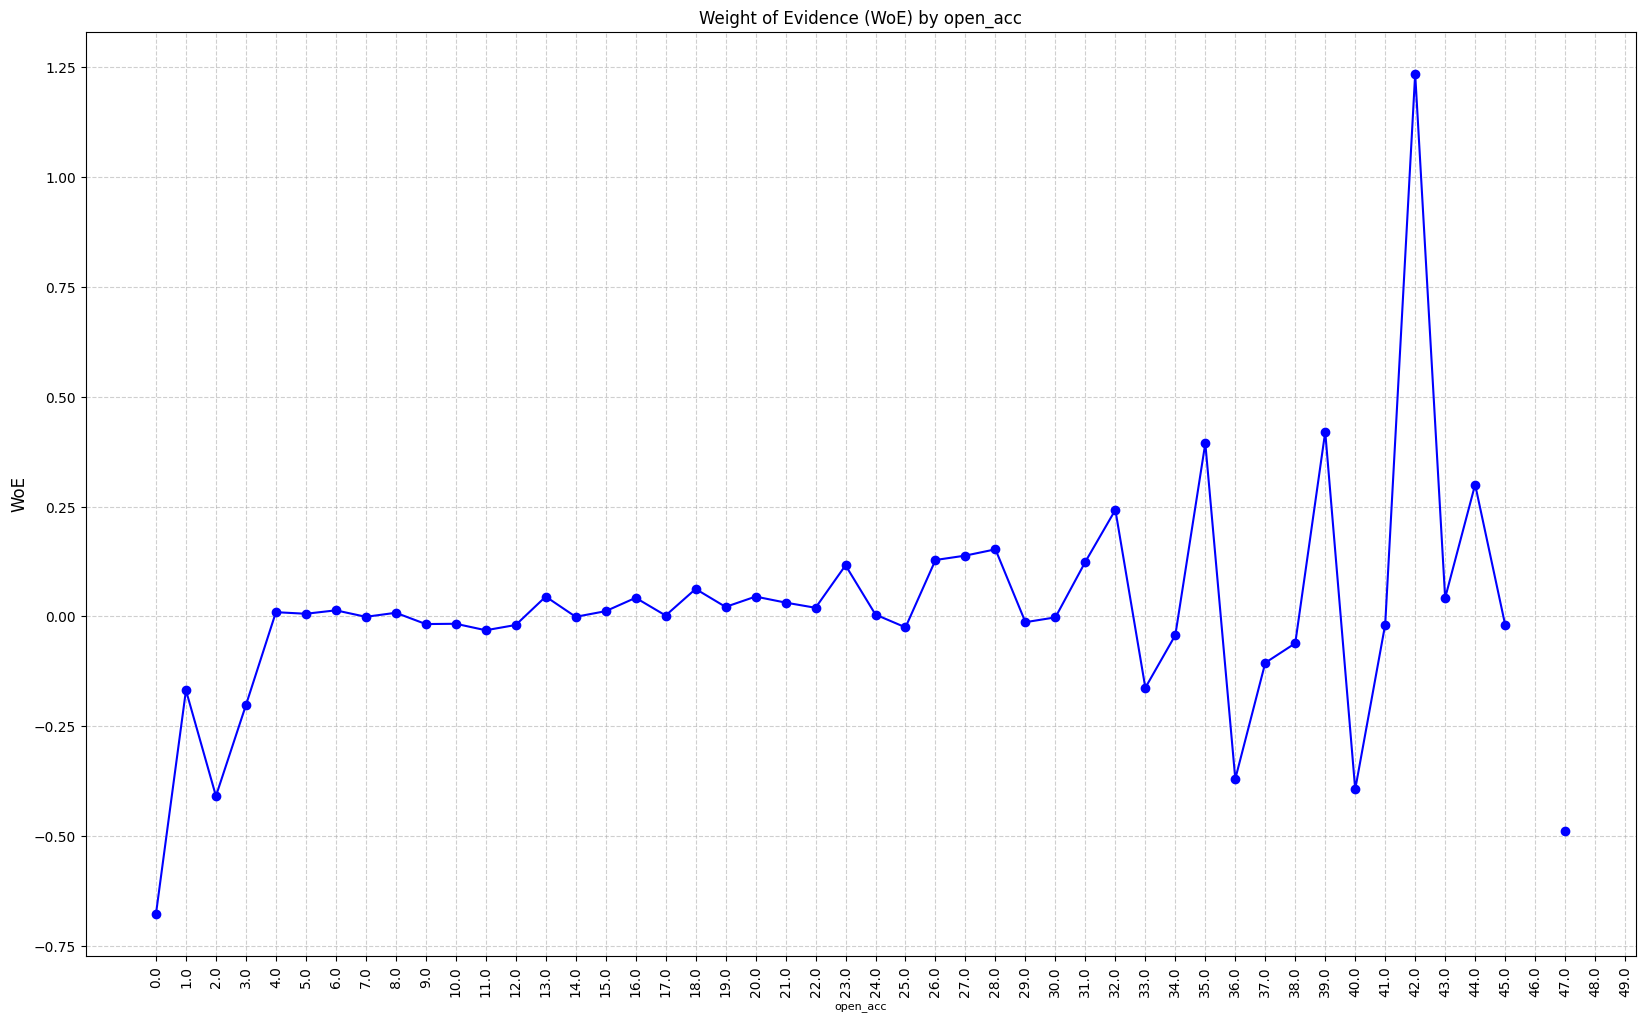

In [83]:
plot_WoE(df1, "open_acc", 90)

In [403]:
X["open_acc:<3,12>"] = np.where(df["open_acc"].isin(range(3,13)), 1, 0)
X["open_acc:<13,24>"] = np.where(df["open_acc"].isin(range(13,25)), 1, 0)

In [85]:
Woe_continuous(df,df["good_bad"], "pub_rec" )

pub_rec   n_obs  prob_good  prob_bad    n_good    n_bad     good%  \
0       0.0  404922   0.889789  0.110211  360295.0  44627.0  0.867518   
1       1.0   53051   0.894969  0.105031   47479.0   5572.0  0.114320   
2       2.0    5624   0.903450  0.096550    5081.0    543.0  0.012234   
3       3.0    1611   0.916201  0.083799    1476.0    135.0  0.003554   
4       4.0     520   0.909615  0.090385     473.0     47.0  0.001139   
5       5.0     276   0.909420  0.090580     251.0     25.0  0.000604   
6       6.0     136   0.926471  0.073529     126.0     10.0  0.000303   
7       7.0      62   0.919355  0.080645      57.0      5.0  0.000137   
8       8.0      29   0.965517  0.034483      28.0      1.0  0.000067   
9       9.0      16   0.812500  0.187500      13.0      3.0  0.000031   
10     10.0      13   1.000000  0.000000      13.0      0.0  0.000031   
11     11.0       8   1.000000  0.000000       8.0      0.0  0.000019   
12     12.0       2   1.000000  0.000000       2.0      0.0  0.000005   
13     13.0       2   1.000000  0.000000       2.0      0.0  0.000005   
14     14.0       1   1.000000  0.000000       1.0      0.0  0.000002   
15     15.0       1   1.000000  0.000000       1.0      0.0  0.000002   
16     16.0       1   1.000000  0.000000       1.0      0.0  0.000002   
17     17.0       1   1.000000  0.000000       1.0      0.0  0.000002   
18     18.0       2   1.000000  0.000000       2.0      0.0  0.000005   
19     19.0       1   1.000000  0.000000       1.0      0.0  0.000002   
20     21.0       1   1.000000  0.000000       1.0      0.0  0.000002   
21     34.0       1   1.000000  0.000000       1.0      0.0  0.000002   
22     40.0       1   1.000000  0.000000       1.0      0.0  0.000002   
23     49.0       1   1.000000  0.000000       1.0      0.0  0.000002   
24     54.0       1   1.000000  0.000000       1.0      0.0  0.000002   
25     63.0       1   1.000000  0.000000       1.0      0.0  0.000002   

        bad%       WoE  
0   0.875589 -0.009260  
1   0.109323  0.044689  
2   0.010654  0.138310  
3   0.002649  0.293972  
4   0.000922  0.211104  
5   0.000491  0.208733  
6   0.000196  0.435853  
7   0.000098  0.335769  
8   0.000020  1.234360  
9   0.000059 -0.631507  
10  0.000000       inf  
11  0.000000       inf  
12  0.000000       inf  
13  0.000000       inf  
14  0.000000       inf  
15  0.000000       inf  
16  0.000000       inf  
17  0.000000       inf  
18  0.000000       inf  
19  0.000000       inf  
20  0.000000       inf  
21  0.000000       inf  
22  0.000000       inf  
23  0.000000       inf  
24  0.000000       inf  
25  0.000000       inf

In [404]:
X["pub_rec:0"] = np.where(df["pub_rec"] == 0, 1, 0)
X["pub_rec:1"] = np.where(df["pub_rec"] == 1, 1, 0)

In [87]:
df_tmp = df.loc[df["total_acc"].isin(range(5, 53))]
df1 = Woe_continuous(df_tmp, df_tmp["good_bad"],"total_acc")
df1

total_acc  n_obs  prob_good  prob_bad   n_good   n_bad     good%  \
0         5.0   2387   0.862589  0.137411   2059.0   328.0  0.005102   
1         6.0   3612   0.866833  0.133167   3131.0   481.0  0.007759   
2         7.0   4850   0.870103  0.129897   4220.0   630.0  0.010457   
3         8.0   6280   0.871656  0.128344   5474.0   806.0  0.013565   
4         9.0   7632   0.875655  0.124345   6683.0   949.0  0.016561   
5        10.0   9177   0.877302  0.122698   8051.0  1126.0  0.019950   
6        11.0  10573   0.879883  0.120117   9303.0  1270.0  0.023053   
7        12.0  11707   0.882207  0.117793  10328.0  1379.0  0.025593   
8        13.0  13057   0.879298  0.120702  11481.0  1576.0  0.028450   
9        14.0  13962   0.881750  0.118250  12311.0  1651.0  0.030507   
10       15.0  14921   0.886469  0.113531  13227.0  1694.0  0.032777   
11       16.0  15654   0.884950  0.115050  13853.0  1801.0  0.034328   
12       17.0  16410   0.887081  0.112919  14557.0  1853.0  0.036072   
13       18.0  16490   0.891389  0.108611  14699.0  1791.0  0.036424   
14       19.0  16709   0.885331  0.114669  14793.0  1916.0  0.036657   
15       20.0  17073   0.888127  0.111873  15163.0  1910.0  0.037574   
16       21.0  17087   0.889624  0.110376  15201.0  1886.0  0.037668   
17       22.0  17028   0.893587  0.106413  15216.0  1812.0  0.037705   
18       23.0  16719   0.890663  0.109337  14891.0  1828.0  0.036900   
19       24.0  16387   0.890950  0.109050  14600.0  1787.0  0.036179   
20       25.0  15715   0.889278  0.110722  13975.0  1740.0  0.034630   
21       26.0  15240   0.900984  0.099016  13731.0  1509.0  0.034026   
22       27.0  14474   0.895191  0.104809  12957.0  1517.0  0.032108   
23       28.0  13800   0.896159  0.103841  12367.0  1433.0  0.030646   
24       29.0  13206   0.896638  0.103362  11841.0  1365.0  0.029342   
25       30.0  12467   0.899094  0.100906  11209.0  1258.0  0.027776   
26       31.0  11483   0.895585  0.104415  10284.0  1199.0  0.025484   
27       32.0  11027   0.898794  0.101206   9911.0  1116.0  0.024560   
28       33.0  10006   0.893464  0.106536   8940.0  1066.0  0.022153   
29       34.0   9360   0.902457  0.097543   8447.0   913.0  0.020932   
30       35.0   8614   0.898653  0.101347   7741.0   873.0  0.019182   
31       36.0   7887   0.895017  0.104983   7059.0   828.0  0.017492   
32       37.0   7319   0.906955  0.093045   6638.0   681.0  0.016449   
33       38.0   6545   0.900382  0.099618   5893.0   652.0  0.014603   
34       39.0   6153   0.901024  0.098976   5544.0   609.0  0.013738   
35       40.0   5580   0.899821  0.100179   5021.0   559.0  0.012442   
36       41.0   5075   0.899113  0.100887   4563.0   512.0  0.011307   
37       42.0   4640   0.901293  0.098707   4182.0   458.0  0.010363   
38       43.0   4177   0.892985  0.107015   3730.0   447.0  0.009243   
39       44.0   3819   0.899188  0.100812   3434.0   385.0  0.008509   
40       45.0   3377   0.893693  0.106307   3018.0   359.0  0.007479   
41       46.0   2936   0.894414  0.105586   2626.0   310.0  0.006507   
42       47.0   2726   0.900954  0.099046   2456.0   270.0  0.006086   
43       48.0   2419   0.894171  0.105829   2163.0   256.0  0.005360   
44       49.0   2125   0.894588  0.105412   1901.0   224.0  0.004711   
45       50.0   1919   0.904117  0.095883   1735.0   184.0  0.004299   
46       51.0   1636   0.899144  0.100856   1471.0   165.0  0.003645   
47       52.0   1601   0.919425  0.080575   1472.0   129.0  0.003648   

        bad%       WoE  
0   0.006627 -0.261547  
1   0.009719 -0.225269  
2   0.012730 -0.196639  
3   0.016286 -0.182828  
4   0.019175 -0.146596  
5   0.022752 -0.131385  
6   0.025661 -0.107190  
7   0.027864 -0.085010  
8   0.031844 -0.112706  
9   0.033360 -0.089398  
10  0.034228 -0.043342  
11  0.036390 -0.058350  
12  0.037441 -0.037244  
13  0.036188  0.006496  
14  0.038714 -0.054595  
15  0.038593 -0.026755  
16  0.038108 -0.011607  
17  0.036613  0.029407  


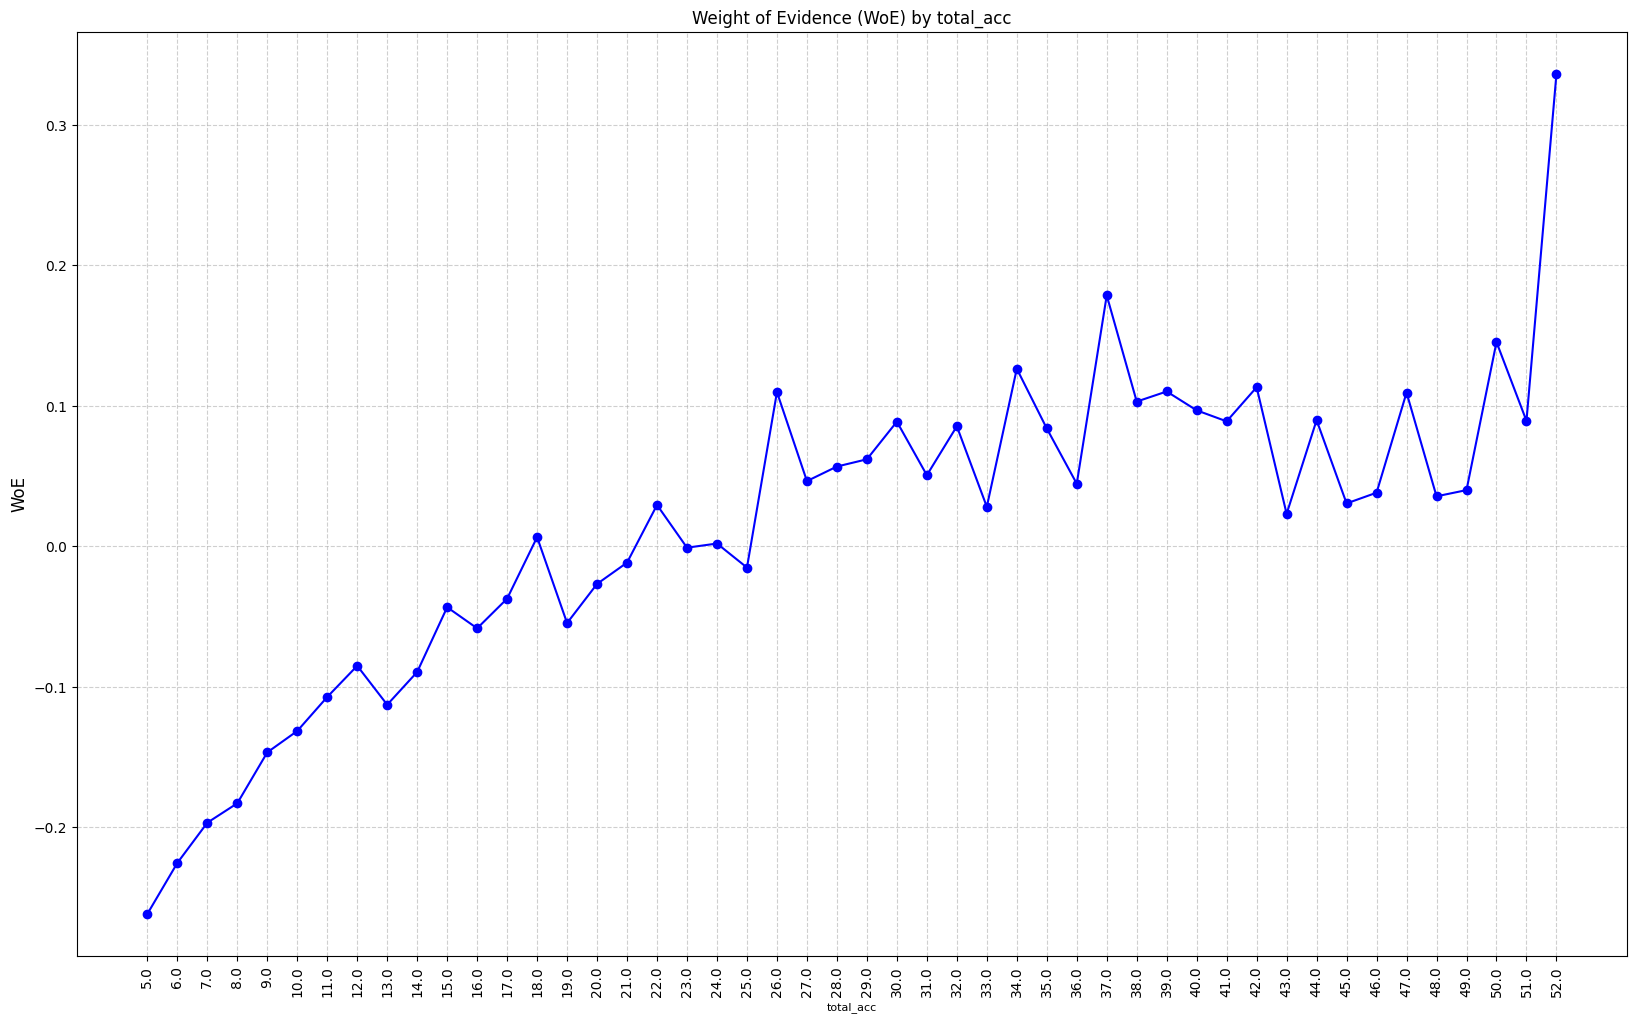

In [88]:
plot_WoE(df1, "total_acc", 90)

In [406]:
X["total_acc:<5"] = np.where(df["total_acc"]<5, 1, 0)
X["total_acc:<5,14>)"] = np.where(df["total_acc"].isin(range(5,15)), 1, 0)
X["total_acc:<14,25>)"] = np.where(df["total_acc"].isin(range(14,26)), 1, 0)
X["total_acc:<25,37>)"] = np.where(df["total_acc"].isin(range(25,38)), 1, 0)
X["total_acc:<37,53>)"] = np.where(df["total_acc"].isin(range(37,53)), 1, 0)

In [156]:
df["out_prncp_cut"] = pd.cut(df["out_prncp"], 50)
df1 = Woe_continuous(df, df["good_bad"], "out_prncp_cut")
df1

C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_df= pd.concat([df1.groupby(df1.columns.values[0], as_index  = False)[df1.columns.values[1]].count(),
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\3393307416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)
C:\Users\macko\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs

out_prncp_cut   n_obs  prob_good  prob_bad    n_good    n_bad  \
0        (-32.16, 643.208]  235779   0.816180  0.183820  192438.0  43341.0   
1      (643.208, 1286.415]    9982   0.982468  0.017532    9807.0    175.0   
2     (1286.415, 1929.623]   11770   0.978080  0.021920   11512.0    258.0   
3      (1929.623, 2572.83]   12897   0.977049  0.022951   12601.0    296.0   
4      (2572.83, 3216.038]   13729   0.972904  0.027096   13357.0    372.0   
5     (3216.038, 3859.246]   13060   0.970980  0.029020   12681.0    379.0   
6     (3859.246, 4502.453]   11563   0.969558  0.030442   11211.0    352.0   
7     (4502.453, 5145.661]   10666   0.970092  0.029908   10347.0    319.0   
8     (5145.661, 5788.868]    9710   0.964573  0.035427    9366.0    344.0   
9     (5788.868, 6432.076]    8838   0.965037  0.034963    8529.0    309.0   
10    (6432.076, 7075.284]    8679   0.969467  0.030533    8414.0    265.0   
11    (7075.284, 7718.491]    7616   0.962185  0.037815    7328.0    288.0   
12    (7718.491, 8361.699]    8621   0.971349  0.028651    8374.0    247.0   
13    (8361.699, 9004.906]    7788   0.962763  0.037237    7498.0    290.0   
14    (9004.906, 9648.114]    8076   0.968301  0.031699    7820.0    256.0   
15   (9648.114, 10291.322]    7930   0.966456  0.033544    7664.0    266.0   
16  (10291.322, 10934.529]    6269   0.953422  0.046578    5977.0    292.0   
17  (10934.529, 11577.737]    6191   0.963818  0.036182    5967.0    224.0   
18  (11577.737, 12220.944]    5997   0.961981  0.038019    5769.0    228.0   
19  (12220.944, 12864.152]    5958   0.971299  0.028701    5787.0    171.0   
20   (12864.152, 13507.36]    5020   0.955976  0.044024    4799.0    221.0   
21   (13507.36, 14150.567]    4201   0.965008  0.034992    4054.0    147.0   
22  (14150.567, 14793.775]    3983   0.963846  0.036154    3839.0    144.0   
23  (14793.775, 15436.982]    3996   0.961461  0.038539    3842.0    154.0   
24   (15436.982, 16080.19]    3761   0.964371  0.035629    3627.0    134.0   
25   (16080.19, 16723.398]    3901   0.965393  0.034607    3766.0    135.0   
26  (16723.398, 17366.605]    3055   0.957119  0.042881    2924.0    131.0   
27  (17366.605, 18009.813]    2666   0.959115  0.040885    2557.0    109.0   
28   (18009.813, 18653.02]    2389   0.961490  0.038510    2297.0     92.0   
29   (18653.02, 19296.228]    2378   0.957107  0.042893    2276.0    102.0   
30  (19296.228, 19939.436]    2511   0.970530  0.029470    2437.0     74.0   
31  (19939.436, 20582.643]    2269   0.960776  0.039224    2180.0     89.0   
32  (20582.643, 21225.851]    1755   0.946439  0.053561    1661.0     94.0   
33  (21225.851, 21869.058]    1473   0.950441  0.049559    1400.0     73.0   
34  (21869.058, 22512.266]    1540   0.951948  0.048052    1466.0     74.0   
35  (22512.266, 23155.474]    1476   0.964092  0.035908    1423.0     53.0   
36  (23155.474, 23798.681]    1319   0.960576  0.039424    1267.0     52.0   
37  (23798.681, 24441.889]    1055   0.945024  0.054976     997.0     58.0   
38  (24441.889, 25085.096]    1039   0.950914  0.049086     988.0     51.0   
39  (25085.096, 25728.304]     809   0.949320  0.050680     768.0     41.0   
40  (25728.304, 26371.512]     675   0.943704  0.056296     637.0     38.0   
41  (26371.512, 27014.719]     734   0.946866  0.053134     695.0     39.0   
42  (27014.719, 27657.927]     638   0.963950  0.036050     615.0     23.0   
43  (27657.927, 28301.134]     732   0.957650  0.042350     701.0     31.0   
44  (28301.134, 28944.342]     722   0.965374  0.034626     697.0     25.0   
45   (28944.342, 29587.55]     663   0.945701  0.054299     627.0     36.0   
46   (29587.55, 30230.757]     280   0.896429  0.103571     251.0     29.0   
47  (30230.757, 30873.965]      95   0.736842  0.263158      70.0     25.0   
48  (30873.965, 31517.172]      23   0.391304  0.608696       9.0     14.0   
49   (31517.172, 32160.38]       8   0.000000  1.000000       0.0      8.0   

       good%      bad%       WoE  

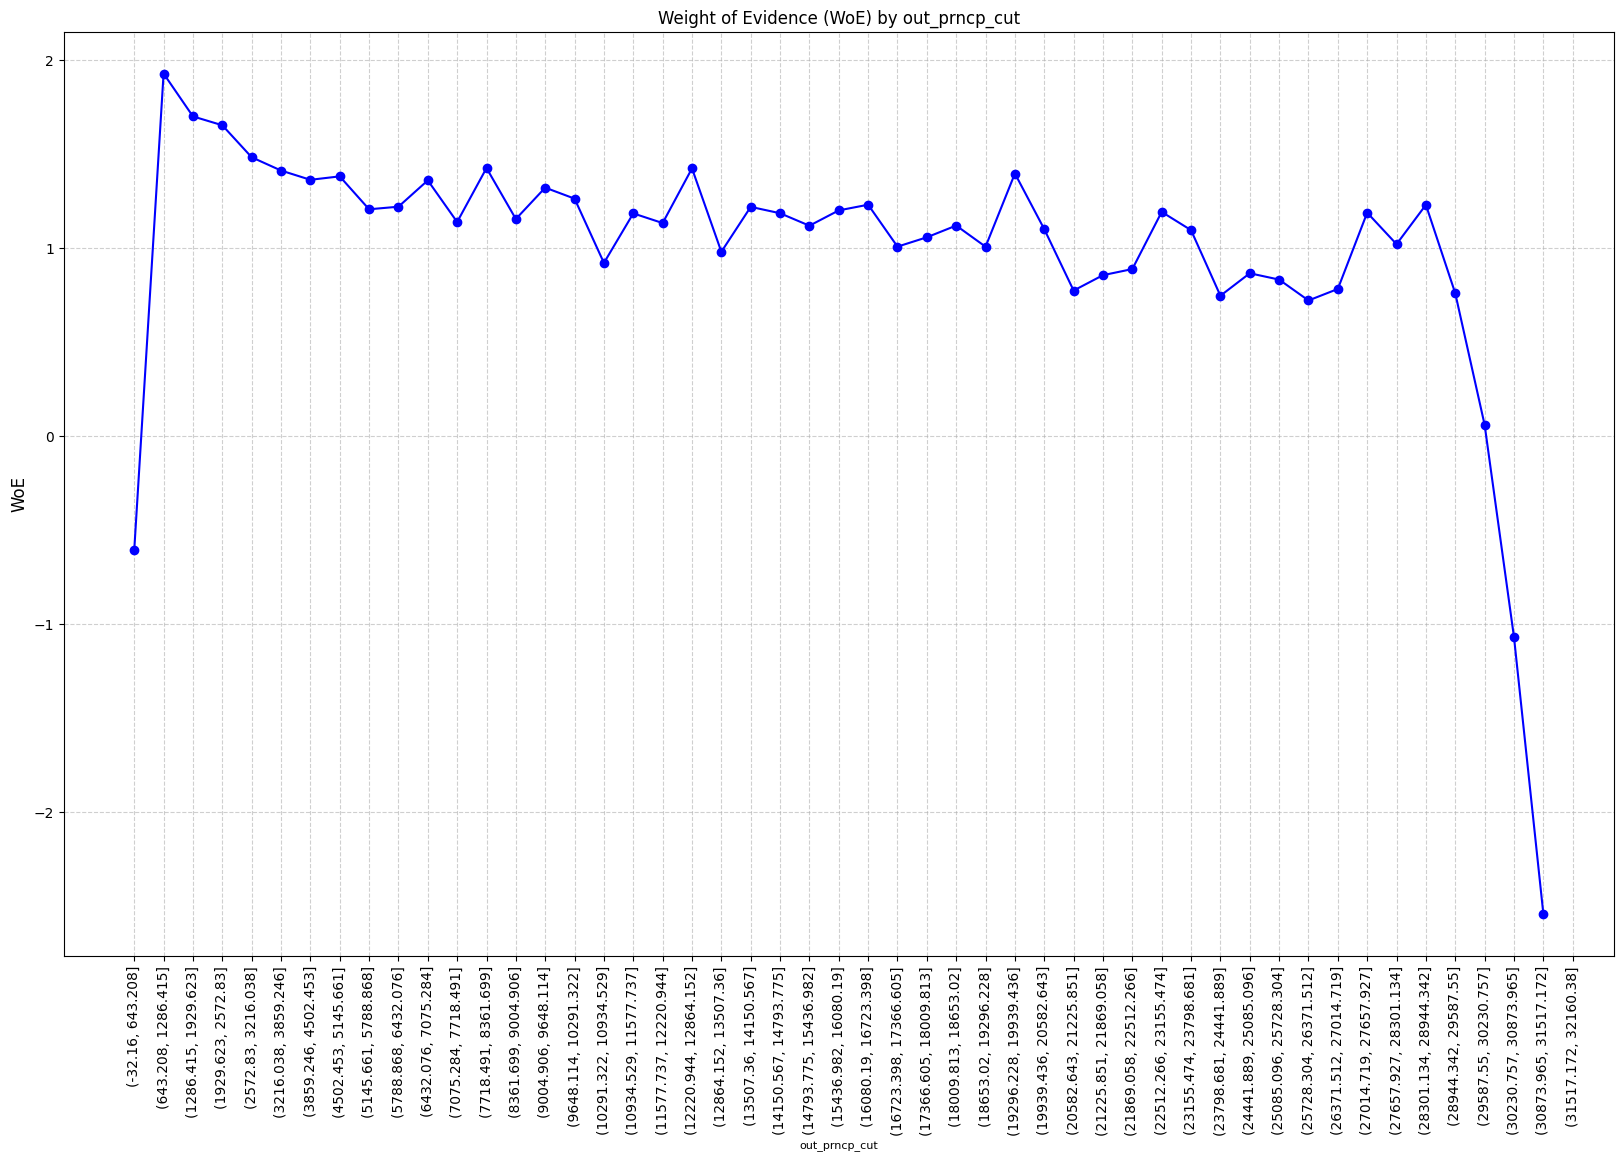

In [159]:
plot_WoE(df1, "out_prncp_cut", 90)

In [407]:
X["out_prncp:0"] = np.where(df["out_prncp"] == 0, 1, 0)
X["out_prncp:600-2500"] = np.where(df["out_prncp"].isin(range(600, 2500)), 1, 0)
X["out_prncp:2500-5100"] = np.where(df["out_prncp"].isin(range(2500, 5100)), 1, 0)
X["out_prncp:5100-10000"] = np.where(df["out_prncp"].isin(range(5100, 10000)), 1, 0)
X["out_prncp:10000-13000"] = np.where(df["out_prncp"].isin(range(10000, 13000)), 1, 0)
X["out_prncp:13000-17000"] = np.where(df["out_prncp"].isin(range(13000, 17000)), 1, 0)
X["out_prncp:17000-19000"] = np.where(df["out_prncp"].isin(range(17000, 19000)), 1, 0)
X["out_prncp:17000-19000"] = np.where(df["out_prncp"].isin(range(19000, 20000)), 1, 0)
X["out_prncp:20000-23000"] = np.where(df["out_prncp"].isin(range(20000, 23000)), 1, 0)
X["out_prncp:23000-25000"] = np.where(df["out_prncp"].isin(range(23000, 25000)), 1, 0)


C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1344454888.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["out_prncp:0"] = np.where(df["out_prncp"] == 0, 1, 0)
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1344454888.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["out_prncp:600-2500"] = np.where(df["out_prncp"].isin(range(600, 2500)), 1, 0)
C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1344454888.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

In [161]:
#dependent variable
y = df.loc[:, "good_bad"]
y

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: good_bad, Length: 466285, dtype: int64

<h2> Features analysis

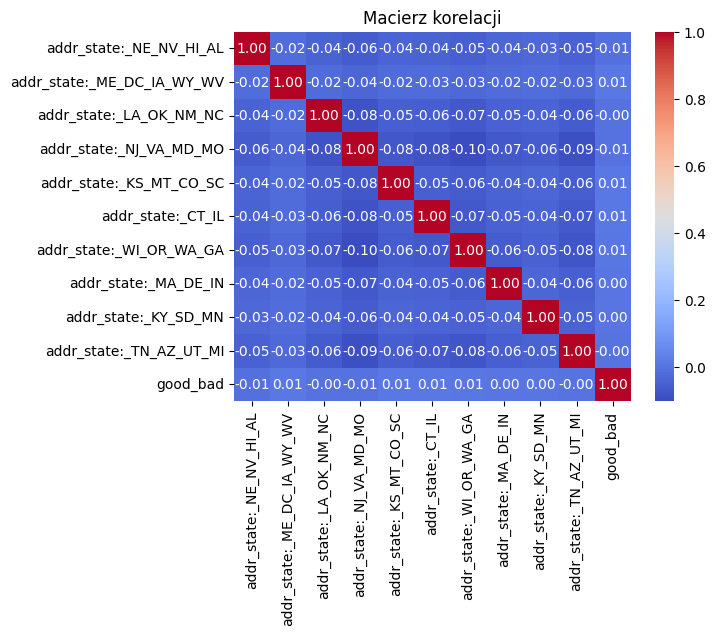

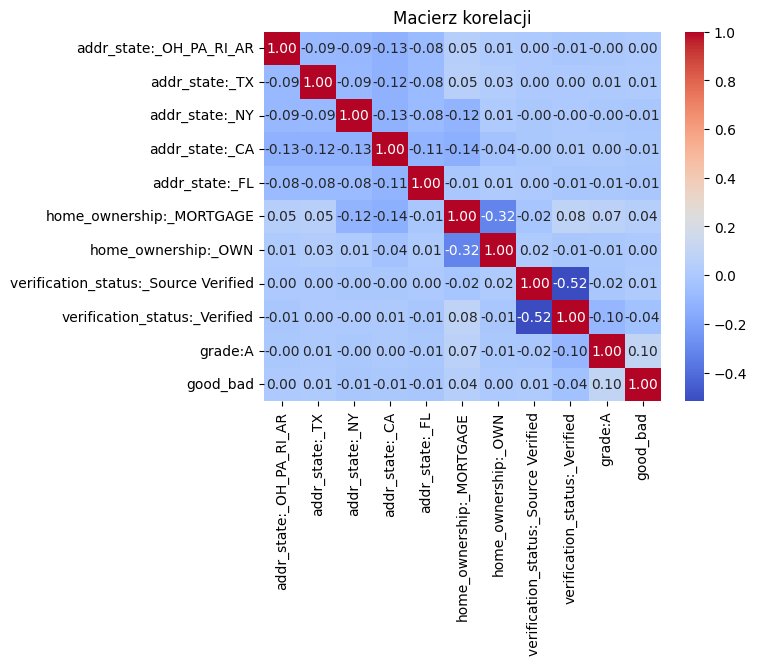

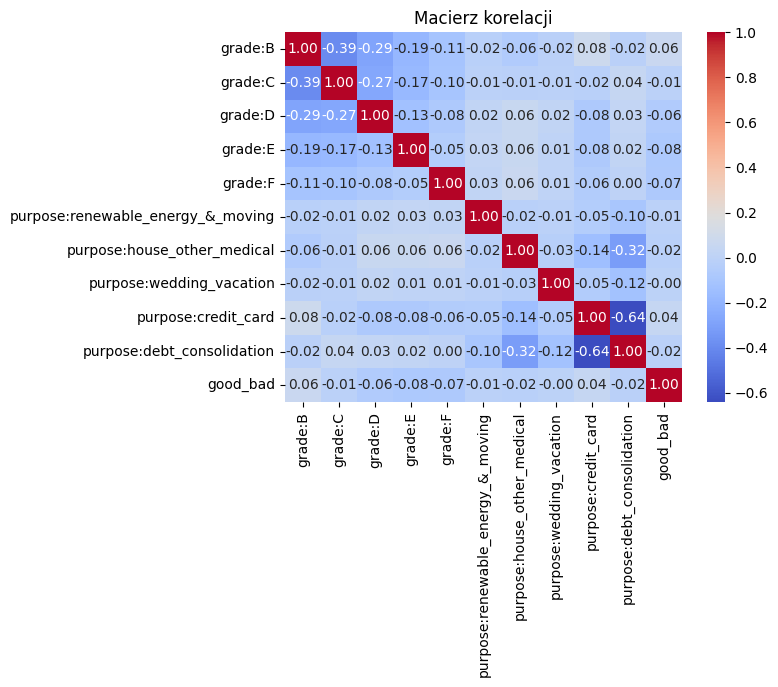

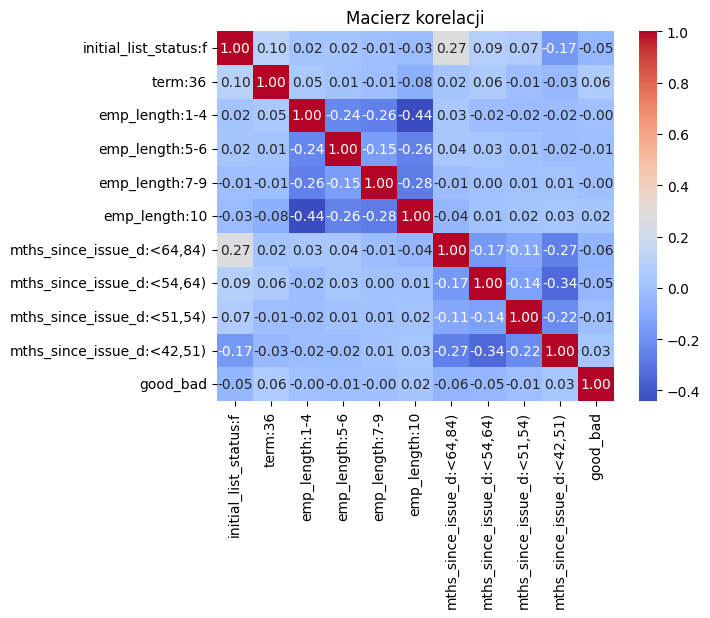

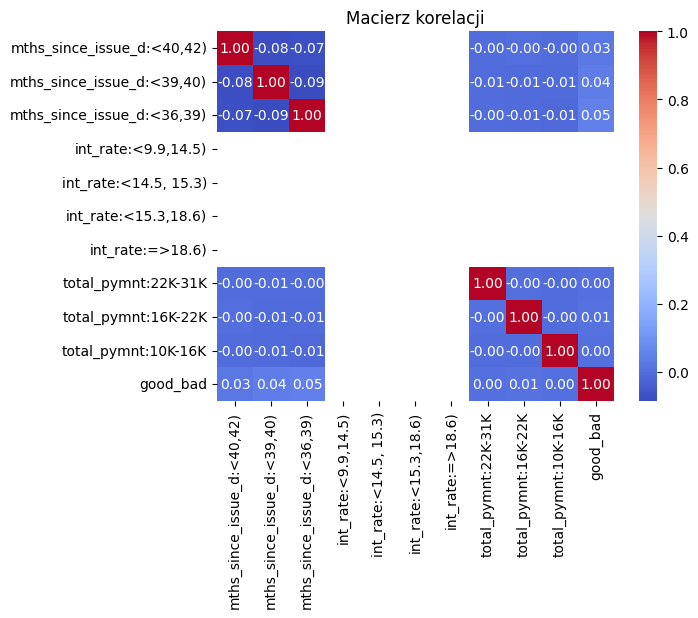

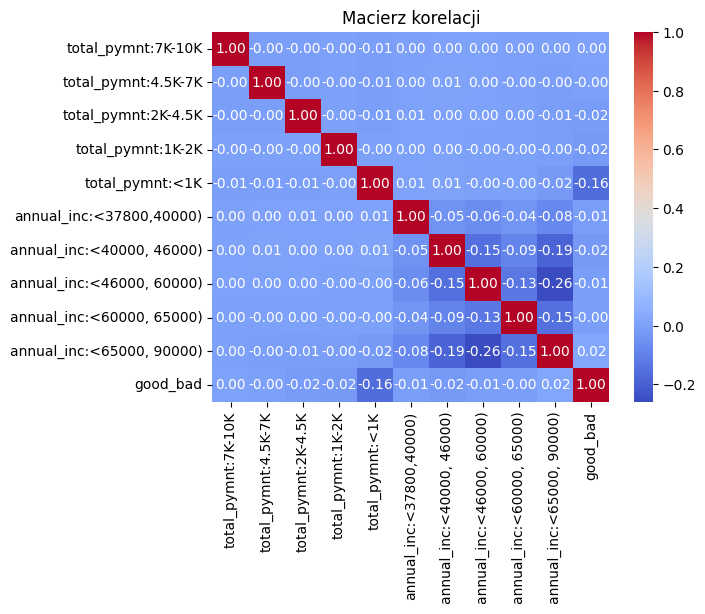

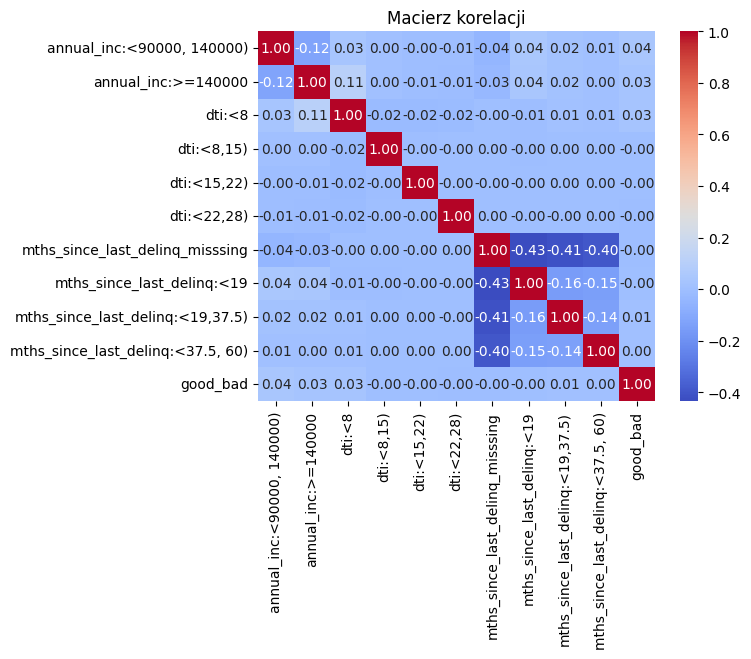

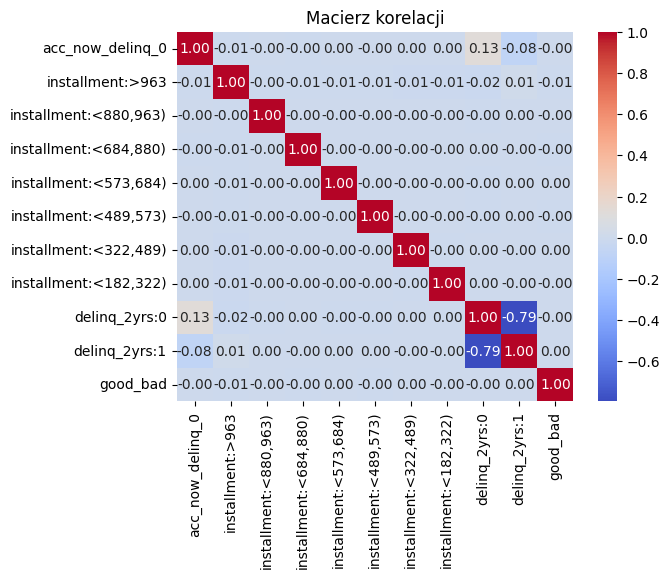

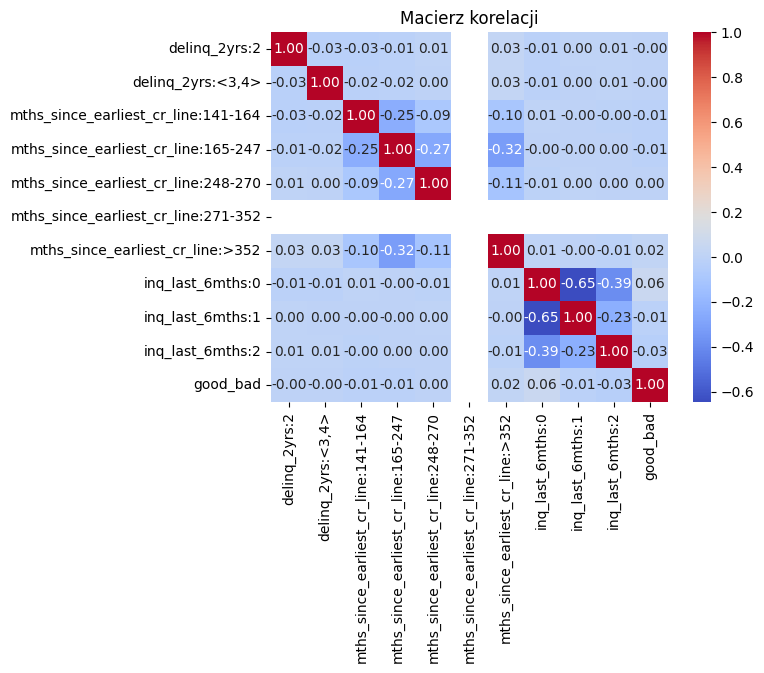

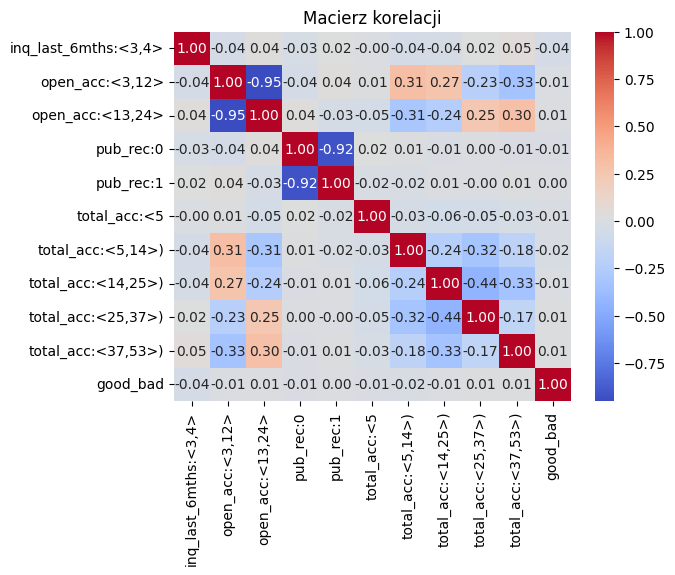

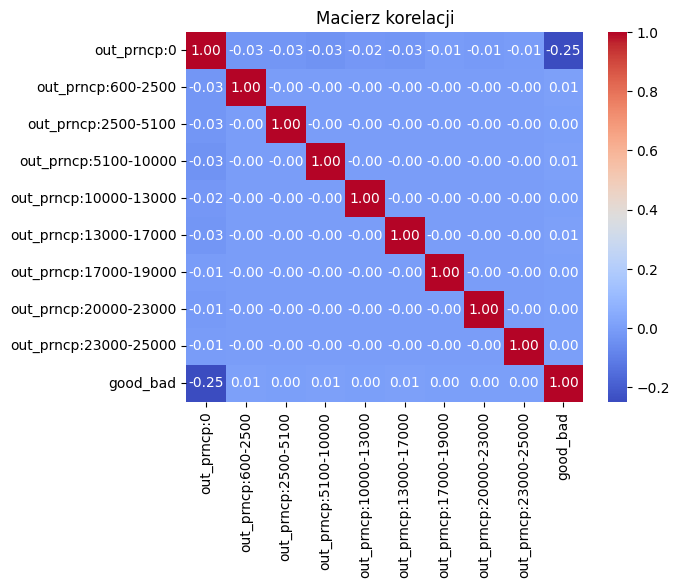

In [409]:
def Correlation_Matrices (X, y):
    n_features = X.shape[1]
    for i in range(0,n_features, 10):
        x_tmp = pd.concat((X.iloc[:,i:i+10], y), axis =1)
        korelacja = x_tmp.corr(method='spearman')
        sns.heatmap(korelacja, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Macierz korelacji")
        plt.show()
    
Correlation_Matrices(X, y)

In [410]:
def IV(X, y, feature):
    df1 = Woe_discrit(X, y, feature)
    df1["IV"] = (df1["good%"]- df1["bad%"])*df1["WoE"]
    IV = df1["IV"].sum()
    return IV

def IV_significant(X, y):
    features = X.columns
    values = []
    for feature in features:
        values.append(IV(X,y, feature))
    df1 = pd.DataFrame({
        'Feature': features,
        'IV': values
    })
    df_s = df1.sort_values("IV")
    df_ret = df_s.loc[df_s["IV"]>=0.015]
    return df_ret
sig = IV_significant(X,y).loc[:, "Feature"]
sig_l = list(sig)
sig_l



['inq_last_6mths:<3,4>',
 'purpose:credit_card',
 'mths_since_issue_d:<39,40)',
 'verification_status:_Verified',
 'home_ownership:_MORTGAGE',
 'mths_since_issue_d:<54,64)',
 'annual_inc:<90000, 140000)',
 'initial_list_status:f',
 'mths_since_issue_d:<64,84)',
 'mths_since_issue_d:<36,39)',
 'inq_last_6mths:0',
 'grade:D',
 'grade:F',
 'term:36',
 'grade:B',
 'grade:E',
 'total_pymnt:<1K',
 'grade:A',
 'out_prncp:0']

In [508]:
class LogisticRegression_p_values:
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)
    
    def fit(self,X,y):
        self.model.fit(X,y)
        weights = np.exp(-self.model.decision_function(X))/(1+np.exp(-self.model.decision_function(X)))**2
        weights = np.tile(weights,(X.shape[1], 1)).T
        Fisher_matrix = np.dot(X.T, (weights*X))
        Cramer_Rao = np.diagonal(np.linalg.inv(Fisher_matrix))
        sd = np.sqrt(Cramer_Rao)
        z_score = self.model.coef_/sd
        p_value = [(2*stat.norm.sf(abs(x))) for x in z_score]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_value = p_value

model_p = LogisticRegression_p_values()
epsilon = 1e-8  #adding noise to enable matrix inversion
X_e = X + epsilon * np.random.randn(*X.shape)
model_p.fit(X_e, y)


In [509]:
summary = pd.DataFrame(columns = ['Feature name'], data = X.columns)
summary["coefficent"] = np.transpose(model.coef_)
summary.loc[0] = ['Intercept', model_p.intercept_[0]]
summary["p-value"] = np.transpose(model_p.p_value)
sorted_ = summary.sort_values("p-value")
sorted_


Feature name  coefficent        p-value
18                                grade:A    1.961960   0.000000e+00
53                        total_pymnt:<1K   -2.514377   0.000000e+00
94                            out_prncp:0   -2.009098   0.000000e+00
59             annual_inc:<90000, 140000)    0.570544  9.508488e-204
30                                term:36    0.302132  5.307081e-201
19                                grade:B    1.288900  3.253124e-161
58              annual_inc:<65000, 90000)    0.398618  5.284386e-131
60                    annual_inc:>=140000    0.640348  3.181608e-129
51                    total_pymnt:2K-4.5K   -1.039614   2.565475e-89
20                                grade:C    0.886327   1.834706e-78
36             mths_since_issue_d:<54,64)   -0.352085   1.259507e-59
38             mths_since_issue_d:<42,51)   -0.316823   3.621021e-53
61                                 dti:<8    0.244351   5.893422e-53
37             mths_since_issue_d:<51,54)   -0.309764   1.278926e-43
56              annual_inc:<46000, 60000)    0.224080   4.159803e-38
14               home_ownership:_MORTGAGE    0.151354   1.227903e-36
50                    total_pymnt:4.5K-7K   -0.603079   7.171195e-35
21                                grade:D    0.586399   9.149685e-34
57              annual_inc:<60000, 65000)    0.233218   3.274974e-28
17          verification_status:_Verified   -0.132374   7.446486e-27
81                       inq_last_6mths:0    0.449718   4.668225e-26
16   verification_status:_Source Verified   -0.134431   6.532542e-26
35             mths_since_issue_d:<64,84)   -0.197244   1.611950e-24
65                       installment:>963   -0.236606   3.557847e-24
82                       inq_last_6mths:1    0.381523   1.753618e-19
39             mths_since_issue_d:<40,42)   -0.239587   2.644625e-19
40             mths_since_issue_d:<39,40)   -0.237790   8.142701e-17
3                 addr_state:_KS_MT_CO_SC    0.228072   1.339511e-14
31                         emp_length:1-4    0.125748   1.586186e-14
49                     total_pymnt:7K-10K   -0.470780   1.682552e-14
83                       inq_last_6mths:2    0.308109   5.476455e-14
22                                grade:E    0.342591   2.240971e-11
0                               Intercept    0.904594   3.455405e-11
26               purpose:wedding_vacation    0.380410   1.389266e-10
52                      total_pymnt:1K-2K   -1.359082   1.420574e-10
34                          emp_length:10    0.113260   1.473049e-10
45                       int_rate:=>18.6)   -0.112446   1.075736e-09
15                    home_ownership:_OWN    0.109674   6.844387e-09
4                       addr_state:_CT_IL    0.156145   5.964463e-08
84                   inq_last_6mths:<3,4>    0.207665   1.142362e-07
91                     total_acc:<14,25>)   -0.096316   1.729367e-07
10                         addr_state:_TX    0.114547   2.834284e-07
5                 addr_state:_WI_OR_WA_GA    0.128687   6.420282e-07
55              annual_inc:<40000, 46000)    0.088508   2.612395e-06
25            purpose:house_other_medical    0.105661   4.892238e-06
27                    purpose:credit_card    0.073584   7.773102e-06
32                         emp_length:5-6    0.084827   9.598730e-06
48                    total_pymnt:10K-16K   -0.186932   2.821242e-05
54               annual_inc:<37800,40000)    0.146803   1.245311e-04
85                        open_acc:<3,12>    0.117183   2.512438e-04
90                      total_acc:<5,14>)   -0.052711   2.904912e-04
33                         emp_length:7-9    0.053116   4.326969e-04
23                                grade:F    0.182577   6.197049e-04
12                         addr_state:_CA    0.051015   7.232166e-04
29                  initial_list_status:f   -0.041586   9.956809e-04
73                          delinq_2yrs:1    0.202173   1.000810e-03
41             mths_since_issue_d:<36,39)   -0.134250   1.470829e-03
72                         

<h2> Modelling

In [442]:
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_split,y_split, test_size = 0.5, random_state = 42) 

In [443]:
model = LogisticRegression(class_weight='balanced') #due to high imbalance I update the weights 
model.fit(X_train, y_train )

LogisticRegression(class_weight='balanced')

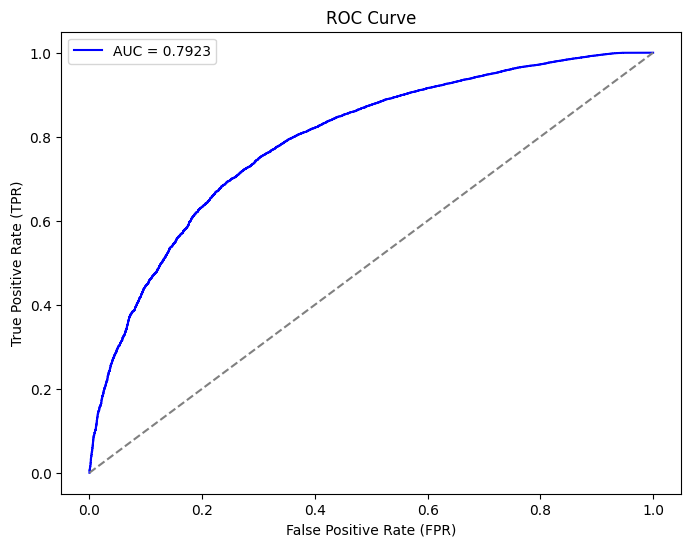

np.float64(0.7923001863401777)

In [444]:
y_score = model.predict_proba(X_valid)[:,1]


fpr, tpr, thresholds = roc_curve(y_valid, y_score)
auc = roc_auc_score(y_valid, y_score)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')  
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()
auc

In [414]:
distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_threshold = thresholds[np.argmin(distances)]
best_threshold

np.float64(0.45768609218170875)

In [ ]:
gini = 2*auc-1
gini

In [198]:
y_pred = np.where(y_score >= best_threshold , 1, 0)
print(accuracy_score(y_valid, y_pred),
matthews_corrcoef(y_valid,y_pred))


0.718774127133911 0.30060279992252625


In [416]:
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_valid, y_pred)
pr_auc = average_precision_score(y_valid, y_pred)

In [417]:
pr_auc

np.float64(0.9384056418028179)

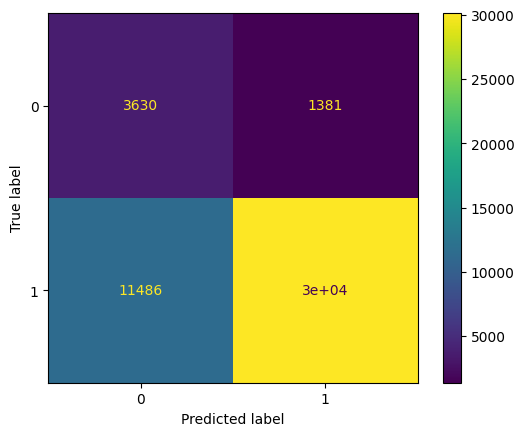

FPR = 0.2759929836364947 FNR = 0.2755936938734784


In [418]:
y_pred = np.where(y_score>= best_threshold,1, 0)
cm = confusion_matrix(y_valid, y_pred)
cmm = ConfusionMatrixDisplay(cm)
cmm.plot()
plt.show()
print(f"FPR = {cm[1,0]/(cm[1,0]+cm[1,1])} FNR = {cm[0,1]/(cm[0,0]+cm[0,1])}") 

In [253]:
y_score = pd.Series(y_score, index = X_valid.index, name="y_score")

In [258]:
y_score = pd.Series(y_score, index = X_valid.index, name="y_score")
y_ks = pd.concat((y_score, y_valid), axis = 1)
good =  y_ks.loc[y_ks["good_bad"] == 1, "y_score"] 
bad = y_ks.loc[y_ks["good_bad"] == 0, "y_score"] 

ks,p = ks_2samp(good, bad)
ks

np.float64(0.4532348092229247)

In [541]:
<h2> Creating Scorecard

SyntaxError: invalid syntax (2327160665.py, line 1)

In [450]:
#Refrence features
feat = ["addr_state:_other", "verification_status:_Not_Verified", "grade:G", "purpose:_home_improvement_&_major_purchase_&_car", "initial_list_status:_w", "emp_length:_0", "term:_60", "mths_since_issue_d_cut:_>84", "int_rate:<9.9", "total_pymnt:>31K","annual_inc:<37800","dti:>=28", "mths_since_last_delinq:>60","acc_now_delinq:>0","installment:<182", "delinq_2yrs:>4", "inq_last_6mths:>4", "open_acc:>24","pub_rec:>1", "total_acc:>53", "mths_since_earliest_cr_line:<141", "out_prncp:>25000"]

In [451]:
ref = pd.DataFrame({
    "Feature name" : feat,
    "coefficent" : 0,
    "p-value": None
})

In [479]:
scorecard

index                                      Feature name  coefficent  \
0       18                                           grade:A    1.961960   
1       53                                   total_pymnt:<1K   -2.514377   
2       94                                       out_prncp:0   -2.009098   
3       59                        annual_inc:<90000, 140000)    0.570544   
4       30                                           term:36    0.302132   
5       19                                           grade:B    1.288900   
6       58                         annual_inc:<65000, 90000)    0.398618   
7       60                               annual_inc:>=140000    0.640348   
8       51                               total_pymnt:2K-4.5K   -1.039614   
9       20                                           grade:C    0.886327   
10      36                        mths_since_issue_d:<54,64)   -0.352085   
11      38                        mths_since_issue_d:<42,51)   -0.316823   
12      61                                            dti:<8    0.244351   
13      37                        mths_since_issue_d:<51,54)   -0.309764   
14      56                         annual_inc:<46000, 60000)    0.224080   
15      14                          home_ownership:_MORTGAGE    0.151354   
16      50                               total_pymnt:4.5K-7K   -0.603079   
17      21                                           grade:D    0.586399   
18      57                         annual_inc:<60000, 65000)    0.233218   
19      17                     verification_status:_Verified   -0.132374   
20      81                                  inq_last_6mths:0    0.449718   
21      16              verification_status:_Source Verified   -0.134431   
22      35                        mths_since_issue_d:<64,84)   -0.197244   
23      65                                  installment:>963   -0.236606   
24      82                                  inq_last_6mths:1    0.381523   
25      39                        mths_since_issue_d:<40,42)   -0.239587   
26      40                        mths_since_issue_d:<39,40)   -0.237790   
27       3                           addr_state:_KS_MT_CO_SC    0.228072   
28      31                                    emp_length:1-4    0.125748   
29      49                                total_pymnt:7K-10K   -0.470780   
30      83                                  inq_last_6mths:2    0.308109   
31      22                                           grade:E    0.342591   
32       0                                         Intercept    0.904599   
33      26                          purpose:wedding_vacation    0.380410   
34      52                                 total_pymnt:1K-2K   -1.359082   
35      34                                     emp_length:10    0.113260   
36      45                                  int_rate:=>18.6)   -0.112446   
37      15                               home_ownership:_OWN    0.109674   
38       4                                 addr_state:_CT_IL    0.156145   
39      84                              inq_last_6mths:<3,4>    0.207665   
40      91                                total_acc:<14,25>)   -0.096316   
41      10                                    addr_state:_TX    0.114547   
42       5                           addr_state:_WI_OR_WA_GA    0.128687   
43      55                         annual_inc:<40000, 46000)    0.088508   
44      25                       purpose:house_other_medical    0.105661   
45      27                               purpose:credit_card    0.073584   
46      32                                    emp_length:5-6    0.084827   
47      48                               total_pymnt:10K-16K   -0.186932   
48      54                          annual_inc:<37800,40000)    0.146803   
49      85                                   open_acc:<3,12>    0.117183   
50      90                                 total_acc:<5,14>)   -0.052711   
51      33                                    emp_len

In [511]:
scorecard = pd.concat((sorted_, ref), axis = 0)
scorecard = summary_table.reset_index()
scorecard["Original feature"] = scorecard["Feature name"].str.split(":").str[0]
scorecard = scorecard.drop(columns = "level_0")


C:\Users\macko\AppData\Local\Temp\ipykernel_6528\1852627366.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scorecard = pd.concat((sorted_, req), axis = 0)


In [512]:
min_score = 300
max_score = 850

In [513]:
min_coef_sum = scorecard.groupby("Original feature")["coefficent"].min().sum()
max_coef_sum = scorecard.groupby("Original feature")["coefficent"].max().sum()
scaler = (max_score-min_score)/(max_coef_sum - min_coef_sum)
scorecard["SCORE"] = scorecard["coefficent"]*scaler

In [515]:
intercept = scorecard[scorecard["Feature name"]=="Intercept"]["coefficent"]
intercept_scaled = intercept*scaler + min_score - scaler*min_coef_sum
scorecard.loc[scorecard["Feature name"] == "Intercept", "SCORE"] = intercept_scaled

In [519]:
scorecard["score"] = np.round(scorecard["SCORE"])
scorecard

index                                      Feature name  coefficent  \
0       18                                           grade:A    1.961960   
1       53                                   total_pymnt:<1K   -2.514377   
2       94                                       out_prncp:0   -2.009098   
3       59                        annual_inc:<90000, 140000)    0.570544   
4       30                                           term:36    0.302132   
5       19                                           grade:B    1.288900   
6       58                         annual_inc:<65000, 90000)    0.398618   
7       60                               annual_inc:>=140000    0.640348   
8       51                               total_pymnt:2K-4.5K   -1.039614   
9       20                                           grade:C    0.886327   
10      36                        mths_since_issue_d:<54,64)   -0.352085   
11      38                        mths_since_issue_d:<42,51)   -0.316823   
12      61                                            dti:<8    0.244351   
13      37                        mths_since_issue_d:<51,54)   -0.309764   
14      56                         annual_inc:<46000, 60000)    0.224080   
15      14                          home_ownership:_MORTGAGE    0.151354   
16      50                               total_pymnt:4.5K-7K   -0.603079   
17      21                                           grade:D    0.586399   
18      57                         annual_inc:<60000, 65000)    0.233218   
19      17                     verification_status:_Verified   -0.132374   
20      81                                  inq_last_6mths:0    0.449718   
21      16              verification_status:_Source Verified   -0.134431   
22      35                        mths_since_issue_d:<64,84)   -0.197244   
23      65                                  installment:>963   -0.236606   
24      82                                  inq_last_6mths:1    0.381523   
25      39                        mths_since_issue_d:<40,42)   -0.239587   
26      40                        mths_since_issue_d:<39,40)   -0.237790   
27       3                           addr_state:_KS_MT_CO_SC    0.228072   
28      31                                    emp_length:1-4    0.125748   
29      49                                total_pymnt:7K-10K   -0.470780   
30      83                                  inq_last_6mths:2    0.308109   
31      22                                           grade:E    0.342591   
32       0                                         Intercept    0.904599   
33      26                          purpose:wedding_vacation    0.380410   
34      52                                 total_pymnt:1K-2K   -1.359082   
35      34                                     emp_length:10    0.113260   
36      45                                  int_rate:=>18.6)   -0.112446   
37      15                               home_ownership:_OWN    0.109674   
38       4                                 addr_state:_CT_IL    0.156145   
39      84                              inq_last_6mths:<3,4>    0.207665   
40      91                                total_acc:<14,25>)   -0.096316   
41      10                                    addr_state:_TX    0.114547   
42       5                           addr_state:_WI_OR_WA_GA    0.128687   
43      55                         annual_inc:<40000, 46000)    0.088508   
44      25                       purpose:house_other_medical    0.105661   
45      27                               purpose:credit_card    0.073584   
46      32                                    emp_length:5-6    0.084827   
47      48                               total_pymnt:10K-16K   -0.186932   
48      54                          annual_inc:<37800,40000)    0.146803   
49      85                                   open_acc:<3,12>    0.117183   
50      90                                 total_acc:<5,14>)   -0.052711   
51      33                                    emp_len

In [540]:
scorecard_final = scorecard.loc[:, ["Feature name", "score"]]
scorecard_final.iloc[12, 1] = scorecard_final.iloc[12, 1] - 1 #rounding mistake
scorecard_final = scorecard_final.sort_values("Feature name").reset_index(drop=True)
scorecard_final

Feature name  score
0                                           Intercept  584.0
1                                    acc_now_delinq:0  -10.0
2                                   acc_now_delinq:>0    0.0
3                                      addr_state:_CA    2.0
4                                   addr_state:_CT_IL    7.0
5                                      addr_state:_FL   -4.0
6                             addr_state:_KS_MT_CO_SC   11.0
7                                addr_state:_KY_SD_MN    3.0
8                             addr_state:_LA_OK_NM_NC   -1.0
9                                addr_state:_MA_DE_IN   -0.0
10                            addr_state:_NJ_VA_MD_MO   -1.0
11                                     addr_state:_NY   -2.0
12                            addr_state:_OH_PA_RI_AR    2.0
13                            addr_state:_TN_AZ_UT_MI   -1.0
14                                     addr_state:_TX    5.0
15                            addr_state:_WI_OR_WA_GA    6.0
16                                  addr_state:_other    0.0
17                                  annual_inc:<37800    0.0
18                           annual_inc:<37800,40000)    7.0
19                          annual_inc:<40000, 46000)    4.0
20                          annual_inc:<46000, 60000)   10.0
21                          annual_inc:<60000, 65000)   11.0
22                          annual_inc:<65000, 90000)   19.0
23                         annual_inc:<90000, 140000)   27.0
24                                annual_inc:>=140000   30.0
25                                      delinq_2yrs:0    9.0
26                                      delinq_2yrs:1    9.0
27                                      delinq_2yrs:2    5.0
28                                  delinq_2yrs:<3,4>    3.0
29                                     delinq_2yrs:>4    0.0
30                                        dti:<15,22)    3.0
31                                        dti:<22,28)   -5.0
32                                             dti:<8   10.0
33                                         dti:<8,15)    2.0
34                                           dti:>=28    0.0
35                                     emp_length:1-4    6.0
36                                      emp_length:10    5.0
37                                     emp_length:5-6    4.0
38                                     emp_length:7-9    2.0
39                                      emp_length:_0    0.0
40                                            grade:A   91.0
41                                            grade:B   60.0
42                                            grade:C   41.0
43                                            grade:D   27.0
44                                            grade:E   16.0
45                                            grade:F    9.0
46                                            grade:G    0.0
47                           home_ownership:_MORTGAGE    7.0
48                                home_ownership:_OWN    5.0
49                             initial_list_status:_w    0.0
50                              initial_list_status:f   -2.0
51                                   inq_last_6mths:0   21.0
52                                   inq_last_6mths:1   18.0
53                                   inq_last_6mths:2   14.0
54                               inq_last_6mths:<3,4>   10.0
55                                  inq_last_6mths:>4    0.0
56                                   installment:<182    0.0
57                              installment:<182,322)   10.0
58                              installment:<322,489)   10.0
59                              installment:<489,573)  -11.0
60                              installment:<573,684)    5.0
61                              installment:<684,880)  -18.0
62                              installment:<880,963)   -7.0
63                                   installment:>963  -11.0
64                              int_rate:<14.5, 15.3)    0.0
65             